# Imports et setup technique

In [1]:
import pandas as pd
from IPython.display import display
idx = pd.IndexSlice
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
mcolorpalette = list(mcolor.TABLEAU_COLORS.values())
import matplotlib.dates as mdates
from pathlib import Path
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure
from bokeh.models import CDSView, ColumnDataSource, GroupFilter, FactorRange, HoverTool
from bokeh.models.annotations import BoxAnnotation
from bokeh.layouts import row, column
from bokeh.models.formatters import NumeralTickFormatter

from functools import partial
from datetime import datetime, date
import sys
project_root = str(Path(sys.path[0]).parents[0].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)
from importlib import reload
from scripts.utils import compute_zscores, process_df, compute_distribution
import scripts.utils as utils

Loading BokehJS ...

# Chargement des données

## Données de base client

In [2]:
cltfields = {
             'client': 'object',
             'V': 'object',
             'groupecompte': 'object',
             'nom': 'object',
             'postalcode': 'object',
             'seg1': 'object',
             'seg2': 'object',
             'seg3': 'object',
             'seg4': 'object',
             'cat': 'object',
             'sscat': 'object',
#              'saiso': 'bool',
             'surcat': 'object',
#              'ecom': 'bool', 
             'sectact': 'object',
             'canal': 'object', 
             'orgacom': 'object', 
             'grpclt1': 'object',
             'grpclt2': 'object',
             'grpclt3': 'object',
             'grpclt4': 'object',
             'grpclt5': 'object',
             'agence': 'object', 
             'condexp': 'object', 
             'pricetype': 'object', 
             'relationtype': 'object',
             'pilcom': 'object',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

clt_fields2 = {
             'client': 'object',
             'V': 'category',
             'groupecompte': 'category',
             'nom': 'object',
             'postalcode': 'category',
             'seg1': 'category',
             'seg2': 'category',
             'seg3': 'category',
             'seg4': 'category',
             'cat': 'category',
             'sscat': 'category',
#              'saiso': 'bool',
             'surcat': 'category',
#              'ecom': 'bool', 
             'sectact': 'category',
             'canal': 'category', 
             'orgacom': 'category', 
             'grpclt1': 'category',
             'grpclt2': 'category',
             'grpclt3': 'category',
             'grpclt4': 'category',
             'grpclt5': 'category',
             'agence': 'category', 
             'condexp': 'category', 
             'pricetype': 'category', 
             'relationtype': 'category',
             'pilcom': 'category',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

filenames = [
    'ref_clt.csv',
    'ref_clt2.csv',
    'export2BRE_clt.csv',
    'exportcomp1ALO.csv',
]
paths = [Path('..') / 'data' / filename for filename in filenames]

df_clts = [
    pd.read_csv(path,
                sep=';',
                encoding='latin1', 
                dtype=cltfields,
                converters={'saiso': lambda x: True if x == 'YES' else False, 
                            'ecom': lambda x: True if x == 'X' else False},
                ) for path in paths
]

df_clt = pd.concat(df_clts, axis=0)
for field, dtype in clt_fields2.items(): 
    if field not in df_clt.columns:
        print(field)
df_clt = df_clt.astype(clt_fields2)
df_clt.sample(5)

client  V groupecompte                       nom postalcode seg1 seg2  \
22902  132492  A         ZCLT      RESTAURANT L ALCYONE      84800   Z3   Z5   
16284  179211  A         ZCLT           REST LE COLIBRI      54000   Z3   Z5   
17526  197349  A         ZCHN  VITALREST RESIDENCE MONT      51270   Z3   Z4   
8143    85727  A         ZHIE                   GOAL RC      22830  NaN  NaN   
601     10715  A         ZHIE          ELIOR ENTREPRISE      75012  NaN  NaN   

      seg3 seg4  cat  ... grpclt5  agence condexp  pricetype relationtype  \
22902   ZK   ZG   ZS  ...     051    1AVI      ST         T1          NDI   
16284   ZK   ZG   ZS  ...     051    1NAN      ST         T1          NDI   
17526   ZJ   ZF   ZN  ...     051    1NAN      ST        NaN          DIR   
8143   NaN  NaN  NaN  ...     NaN     NaN     NaN        NaN          NaN   
601    NaN  NaN  NaN  ...     NaN     NaN     NaN        NaN          NaN   

      pilcom  hier4  hier3  hier2  hier1  
22902    RGL    NaN    NaN    NaN    NaN  
16284    RGL    NaN    NaN    NaN    NaN  
17526    NTL  11194  11195  11196  11197  
8143     NaN    NaN    NaN    NaN    NaN  
601      NaN    NaN    NaN    NaN    NaN  

[5 rows x 31 columns]

In [3]:
# remove emppty client codes
df_clt = df_clt.loc[~df_clt.client.isna()]

# zero pad numeric clients codes
num_clt_mask = df_clt['client'].str.isnumeric()
df_clt.loc[num_clt_mask, 'client'] = df_clt.loc[num_clt_mask, 'client'].str.zfill(10)

#remove duplicated clients
print(f'Clients count before cleansing : {df_clt.client.count()}')
print(f"Duplicated clients before cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")
df_clt = df_clt.loc[~(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False) & df_clt.sectact.isna())]
print(f"Clients count after cleansing : {df_clt.client.count()}")
print(f"Duplicated clients after cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")

# set the index
df_clt.set_index(['orgacom', 'client'], inplace=True, drop=True)

Clients count before cleansing : 104640
Duplicated clients before cleansing: 4634
Clients count after cleansing : 102323
Duplicated clients after cleansing: 0


In [4]:
df_clt.sample(5)

V groupecompte                     nom postalcode seg1  \
orgacom client                                                               
1SOU    0000115248  A         ZCLT                  CRS 44      89300   Z3   
2BRE    0000115419  A         ZCLT       ANSA REST LOCMINE      56500   Z3   
1SOU    0000208474  A         ZCLT              TIKI PIZZA      17480   Z3   
2BRE    0000192872  A         ZLIV   ECOLE GABRIEL LE BRAS      22500  NaN   
1ALO    0000027232  A         ZCRC  AV ENT CERCLE 4HUSSARD      57000   Z3   

                   seg2 seg3 seg4  cat sscat  ...  grpclt5 agence  condexp  \
orgacom client                                ...                            
1SOU    0000115248   Z4   ZI   ZB   ZR    ZI  ...      051   1BAY       ST   
2BRE    0000115419   Z4   ZJ   ZF   ZL   Z12  ...      L51   2MOR       ST   
1SOU    0000208474   Z5   ZK   ZG   ZU    ZN  ...      051   1RCH       ST   
2BRE    0000192872  NaN  NaN  NaN  NaN   NaN  ...      L31    NaN       ST   
1ALO    0000027232   Z4   ZJ   ZF   ZR    ZG  ...      L51   1MET       ST   

                   pricetype relationtype pilcom  hier4  hier3   hier2   hier1  
orgacom client                                                                  
1SOU    0000115248        T3          NDI    RGL    NaN    NaN     NaN     NaN  
2BRE    0000115419       NaN          DIR    BIG  10705  10706  115016  115027  
1SOU    0000208474        T2          NDI    RGL    NaN    NaN     NaN     NaN  
2BRE    0000192872       NaN          NaN    NaN  65398  65399   65400   65338  
1ALO    0000027232       NaN          DIR    BIG  10705  10706   10715   10747  

[5 rows x 29 columns]

In [5]:
if sum(df_clt.index.duplicated()):
    raise RuntimeError('Something went wrong on the client dataframe! Some indices are duplicated!')

In [6]:
print(*df_clt.groupecompte.unique())

ZCLT ZFAC ZCHN ZCFR ZPER ZLIV ZCRC ZHIE ZCOL ZREG ZCTR ZCFE ZCAC ZCFG ZCPP ZCRI ZCRM ZGPE 0100 ZCPD ZCAB


Libellés des segments clients :

In [7]:
path = Path('..') / 'data' / 'libelles_segments.csv'
lib_seg = pd.read_csv(path,
                      sep=';',
                      encoding='latin1',
                      header=None,
                      names=['level', 'code', 'designation'],
                      index_col=['level', 'code']
                     )
lib_seg

designation
level code                     
1     Z1           Distribution
      Z3                    RHD
      Z4                 Divers
2     Z0      Autres clientèles
      Z1                    GMS
...                         ...
6     ZI    Police Pomp Gendarm
      ZJ    Gastro -semi gastro
      ZK          Moyenne gamme
      ZL             Economique
      ZM    Petit déj. exclusif

[136 rows x 1 columns]

## Historiques de vente

In [8]:
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES.csv'
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES_v2.csv'
path_list = [Path('..') / 'data' / filename for filename in ['EXTRACT_LIGNES_VENTES_V3.csv',
                                                             'EXTRACTION_2BRE.csv']]
fields = {'orgacom': pd.CategoricalDtype(['1SOU', '1ALO', '1LRO', '2BRE'], ordered=True),
          'month': 'category',
          'week': 'category',
          'date': 'object',
          'pricetype': 'category',
          'client': 'object',
          'doctype': 'category',
          'origin': pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB', '#', 'SCHR', 'TELE',
                                         'MUEN', 'FRN', 'DFUE'], ordered=True),
          'salesgroup': 'category',
          'material': 'object',
          'brutrevenue': 'float',
          'brutrevcur': 'category', 
          'netrevenue': 'float', 
          'netrevcur': 'category',
          'weight': 'float',
          'weightunit': 'category',
          'margin': 'float', 
          'margincur': 'category', 
          'marginperkg': 'float',
         }

In [9]:
data = [pd.read_csv(path,
                   sep=';',
                   header=None,
                   names=list(fields.keys()),      
                   dtype=fields, 
                   parse_dates=['date'],
                  ) for path in path_list]
data = pd.concat(data, axis=0)
data.sample(5)

orgacom   month    week       date pricetype      client doctype  \
3099719     2BRE  201810  201842 2018-10-16      ZTCE  0000082171    ZC10   
7097171     2BRE  202007  202029 2020-07-16      ZTCE  0000259841    ZC10   
14331060    1SOU  201810  201843 2018-10-27      ZTCE  0000070015    ZC10   
31475939    1LRO  202007  202031 2020-07-31      ZTCN  0000137850    ZC10   
22275662    1ALO  201908  201932 2019-08-07      ZTCN  0000118487    ZC10   

         origin salesgroup            material  brutrevenue brutrevcur  \
3099719     EDI        A26  000000000000045063         5.20        EUR   
7097171     EDI        A11  000000000000028105        43.12        EUR   
14331060    EDI        801  000000000000009342         0.00        EUR   
31475939    EDI        747  000000000000179030        93.67        EUR   
22275662     TV        578  000000000000034986         6.04        EUR   

          netrevenue netrevcur  weight weightunit  margin margincur  \
3099719         4.13       EUR   5.000         KG    0.11       EUR   
7097171        31.93       EUR   6.000         KG  -11.92       EUR   
14331060       -0.53       EUR   0.000         KG   -0.53       EUR   
31475939       88.05       EUR  12.960         KG    0.89       EUR   
22275662        5.74       EUR   0.312         KG    0.19       EUR   

          marginperkg  
3099719          0.02  
7097171         -1.99  
14331060         0.00  
31475939         0.07  
22275662         0.61

## Filtres sur les données
### Filtre sur les types de documents
Définition des types de poste valides et invalides.
PAR CONTRE, on ne filtre plus les documents de type avoir !

In [10]:
valid_doctypes = ['ZC01', 'ZC02', 'ZC10']
invalid_doctypes = ['ZR01', 'ZR02', 'ZA01', 'ZA02', 'ZA03', 'ZA04', 'ZC20']
doctypes = valid_doctypes + invalid_doctypes

In [11]:
if len(data.loc[~data.doctype.isin(doctypes)]) > 0:
    raise RuntimeError(f'An unexpected doctype has been encountered: '
                       f'{data.loc[~data.doctype.isin(doctypes), "doctype"].iloc[0]}!')

In [12]:
order_doctype_mask = data.doctype.isin(valid_doctypes)

## Nettoyage des poids / CA à zéro
On contrôle d'abord qu'il n'y a pas de ligne de commande avec un poids à zéro mais un CA associé

In [13]:
if len(data.loc[order_doctype_mask & (data.weight == 0) & (data.brutrevenue != 0)]) > 0:
    print('Some sales have no weight but have brut revenue!')
data.loc[order_doctype_mask & (data.weight == 0) & (data.brutrevenue != 0), 'material'].unique()

Some sales have no weight but have brut revenue!


array(['FL ACCOR', 'FL39860', 'FL66446', 'FC42378', '000000000000156486',
       'FC34504', 'FC34502', 'FC34503'], dtype=object)

On contrôle que le CA brut des commandes est toujours positif.

In [14]:
if len(data.loc[order_doctype_mask & (data.brutrevenue < 0)]) > 0: 
    raise RuntimeError('Some sales have negative brut revenue!')

## Calcul des indicateurs manquants

In [15]:
data['purchcost'] = data.brutrevenue - data.margin
data['purchcostperkg'] = data.purchcost / data.weight
data['PMVK'] = data.brutrevenue / data.weight
data['marginpercent'] = (data.margin / data.brutrevenue).replace({np.inf: np.nan, -np.inf: np.nan})

## Définition des formats des indicateurs

In [16]:
formats = utils.formats

## Nettoyage des avoirs
### Constat d'erreurs et corrections sur les prix
Il apparaît que certaines erreurs sur les prix qui faussent l'analyse ont eu un impact fort sur les indicateurs :

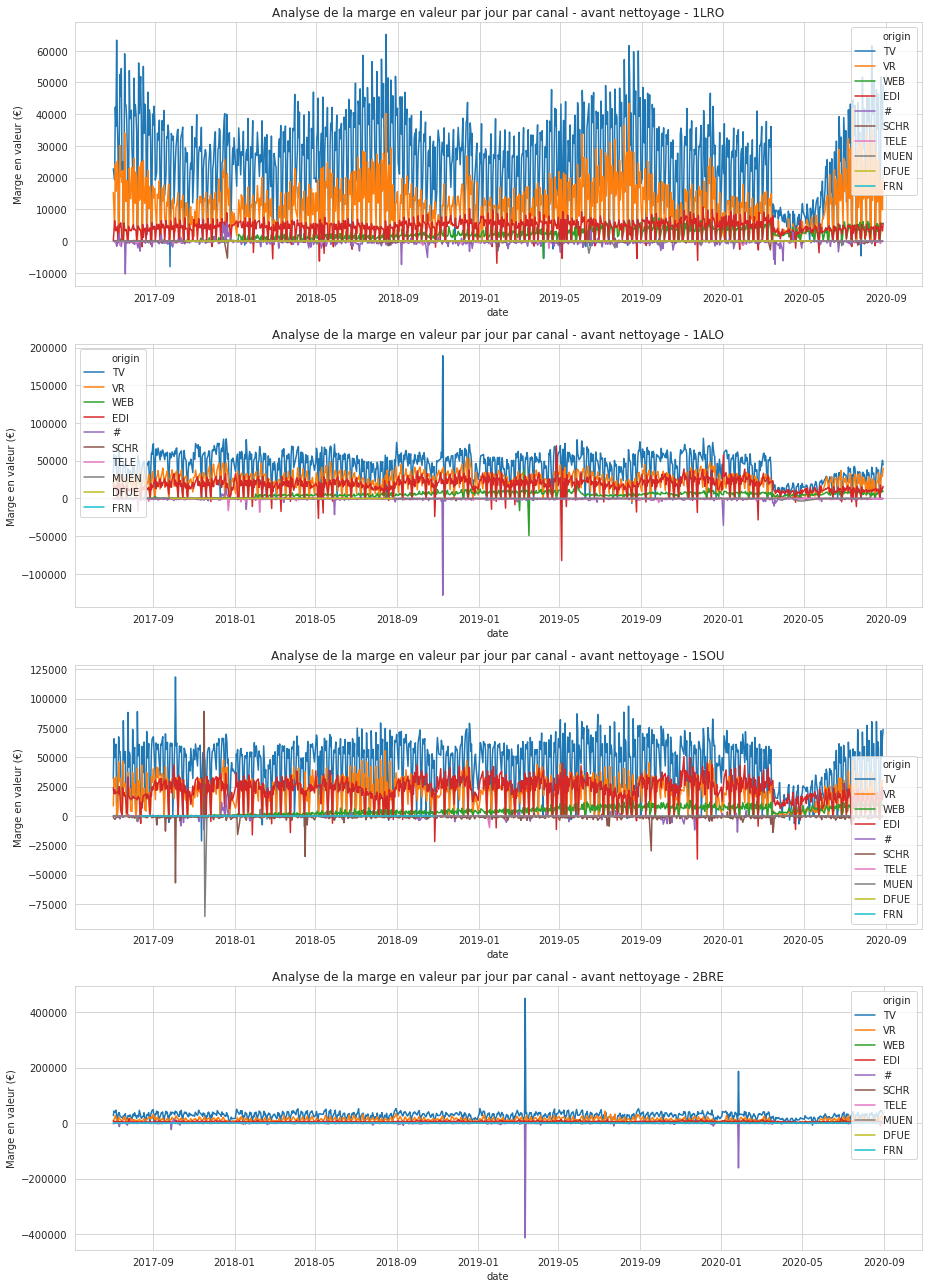

In [17]:
mult_origins_order = ['TV', 'VR', 'WEB', 'EDI', '#', 'SCHR', 'TELE', 'MUEN', 'DFUE', 'FRN']

nrows = len(data.orgacom.unique())
fig, axs = plt.subplots(figsize = (13, 6 * nrows), nrows=nrows)
orgacoms = data.orgacom.unique().tolist()
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .rolling(1, win_type='triang')
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in orgacoms]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_,
                 x='date',
                 y='margin',
                 hue='origin',
                 hue_order=mult_origins_order,
                 ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - avant nettoyage - {orgacoms[i]}')
    axs[i].set_ylabel('Marge en valeur (€)')
fig.tight_layout()

On voit 3 gros pics négatifs qui sont des corrections d'erreur sur les prix, mais pas affectés au canal correspondant.

### Calcul d'une table des avoirs, aggrégée

In [18]:
myfields = ['orgacom',
            'doctype',
            'date',
            'origin',
            'material',
            'client',
            'brutrevenue',
            'weight',
            'PMVK',
            'marginperkg',
            'margin',
            'purchcost',
            'purchcostperkg']

In [19]:
%%time
dfs = []
for suc in data.orgacom.unique():
    print(f'Début du traitement pour {suc}')
    to_process = data.loc[data.orgacom == suc]
    data = data.loc[data.orgacom != suc]
    dfs.append(process_df(to_process))

Début du traitement pour 1LRO
Evolution des indicateurs pendant le traitement : 
margin        -9.685755e-08
brutrevenue   -2.384186e-07
weight        -1.490116e-08
dtype: float64
Début du traitement pour 1ALO
Evolution des indicateurs pendant le traitement : 
margin        -7.450581e-07
brutrevenue    1.192093e-07
weight         7.450581e-08
dtype: float64
Début du traitement pour 1SOU
Evolution des indicateurs pendant le traitement : 
margin        -1.490116e-08
brutrevenue   -1.549721e-06
weight         1.341105e-07
dtype: float64
Début du traitement pour 2BRE
Evolution des indicateurs pendant le traitement : 
margin         2.086163e-07
brutrevenue   -1.788139e-07
weight         4.470348e-08
dtype: float64
CPU times: user 5min 5s, sys: 1min 26s, total: 6min 32s
Wall time: 6min 32s


In [20]:
data = pd.concat(dfs, axis=0)
del(dfs)
data.sample(10)

orgacom   month    week       date pricetype      client doctype  \
4103386     1SOU  201806  201824 2018-06-12      ZTCE  0000066731    ZC10   
228494      1LRO  201708  201731 2017-08-04      ZTCE  0000065164    ZC10   
11651231    1ALO  202005  202022 2020-05-29      ZTCE  0000254925    ZC10   
8849056     1SOU  201907  201927 2019-07-04      ZTCE  0000069595    ZC10   
7861245     1ALO  201905  201920 2019-05-17      ZTCR  0000114093    ZC10   
4035098     1LRO  201906  201923 2019-06-07      ZTCN  0000061248    ZC10   
4845234     1SOU  201808  201832 2018-08-10      ZTCE  0000196998    ZC10   
495062      1LRO  201709  201737 2017-09-13      ZTCE  0000172622    ZC10   
6905609     1SOU  201901  201904 2019-01-27      ZTCE  0000069441    ZC10   
3229649     2BRE  201811  201845 2018-11-07      ZTCE  0000076762    ZC10   

         origin salesgroup            material  ... margincur  marginperkg  \
4103386      TV        787  000000000000041361  ...       EUR         0.32   
228494      EDI        738  000000000000031969  ...       EUR         0.14   
11651231    EDI        H27  000000000000027395  ...       EUR        -0.09   
8849056     EDI        801  000000000000013675  ...       EUR         0.20   
7861245      TV        578  000000000000026125  ...       EUR         2.72   
4035098      TV        765  000000000000008231  ...       EUR         0.30   
4845234     EDI        817  000000000000003800  ...       EUR         0.59   
495062      EDI        738  000000000000132614  ...       EUR         0.26   
6905609     EDI        801  000000000000060327  ...       EUR         0.00   
3229649     EDI        A16  000000000000040920  ...       EUR         0.10   

         purchcost purchcostperkg       PMVK  marginpercent  _duplicated  \
4103386      51.37       3.298234   3.619904       0.088861        False   
228494        7.65       1.020000   1.164000       0.123711        False   
11651231     10.92       1.456000   1.365333      -0.066406        False   
8849056      28.27       4.711667   4.906667       0.039742        False   
7861245       7.28       5.244957   7.961095       0.341176        False   
4035098       4.16       4.160000   4.460000       0.067265        False   
4845234      30.03       4.692187   5.281250       0.111538        False   
495062       10.96      10.960000  11.220000       0.023173        False   
6905609      -0.39           -inf        NaN            NaN        False   
3229649      15.95       1.563725   1.662745       0.059552        False   

          margin  brutrevenue  weight  
4103386     5.01        56.38  15.575  
228494      1.08         8.73   7.500  
11651231   -0.68        10.24   7.500  
8849056     1.17        29.44   6.000  
7861245     3.77        11.05   1.388  
4035098     0.30         4.46   1.000  
4845234     3.77        33.80   6.400  
495062      0.26        11.22   1.000  
6905609     0.39         0.00   0.000  
3229649     1.01        16.96  10.200  

[10 rows x 24 columns]

On peut plotter les indicateurs après nettoyage :

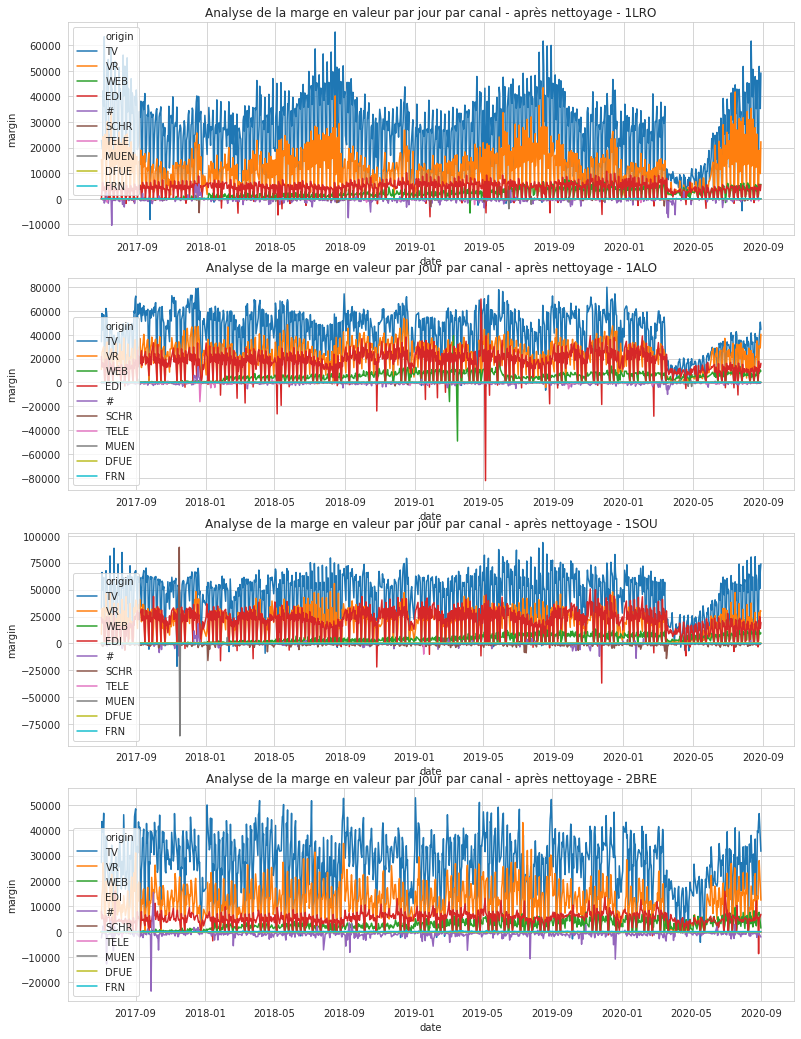

In [21]:
nrows = len(data.orgacom.unique())
fig, axs = plt.subplots(figsize = (13, 6 * nrows), nrows=nrows)
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .fillna(0.)
        .rolling(1, win_type='triang')
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in data.orgacom.unique()]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_,
                 x='date',
                 y='margin',
                 hue='origin',
                 hue_order=mult_origins_order,
                 ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - après nettoyage - {orgacoms[i]}')
fig.tight_layout()

## Affichage des indicateurs par succursale et canal

In [22]:
indicator_map = {
    'Marge (€)': 'margin',
    'CA brut (€)': 'brutrevenue',
    'Tonnage (kg)': 'weight',
}

CPU times: user 24.5 s, sys: 9.1 s, total: 33.6 s
Wall time: 33.3 s


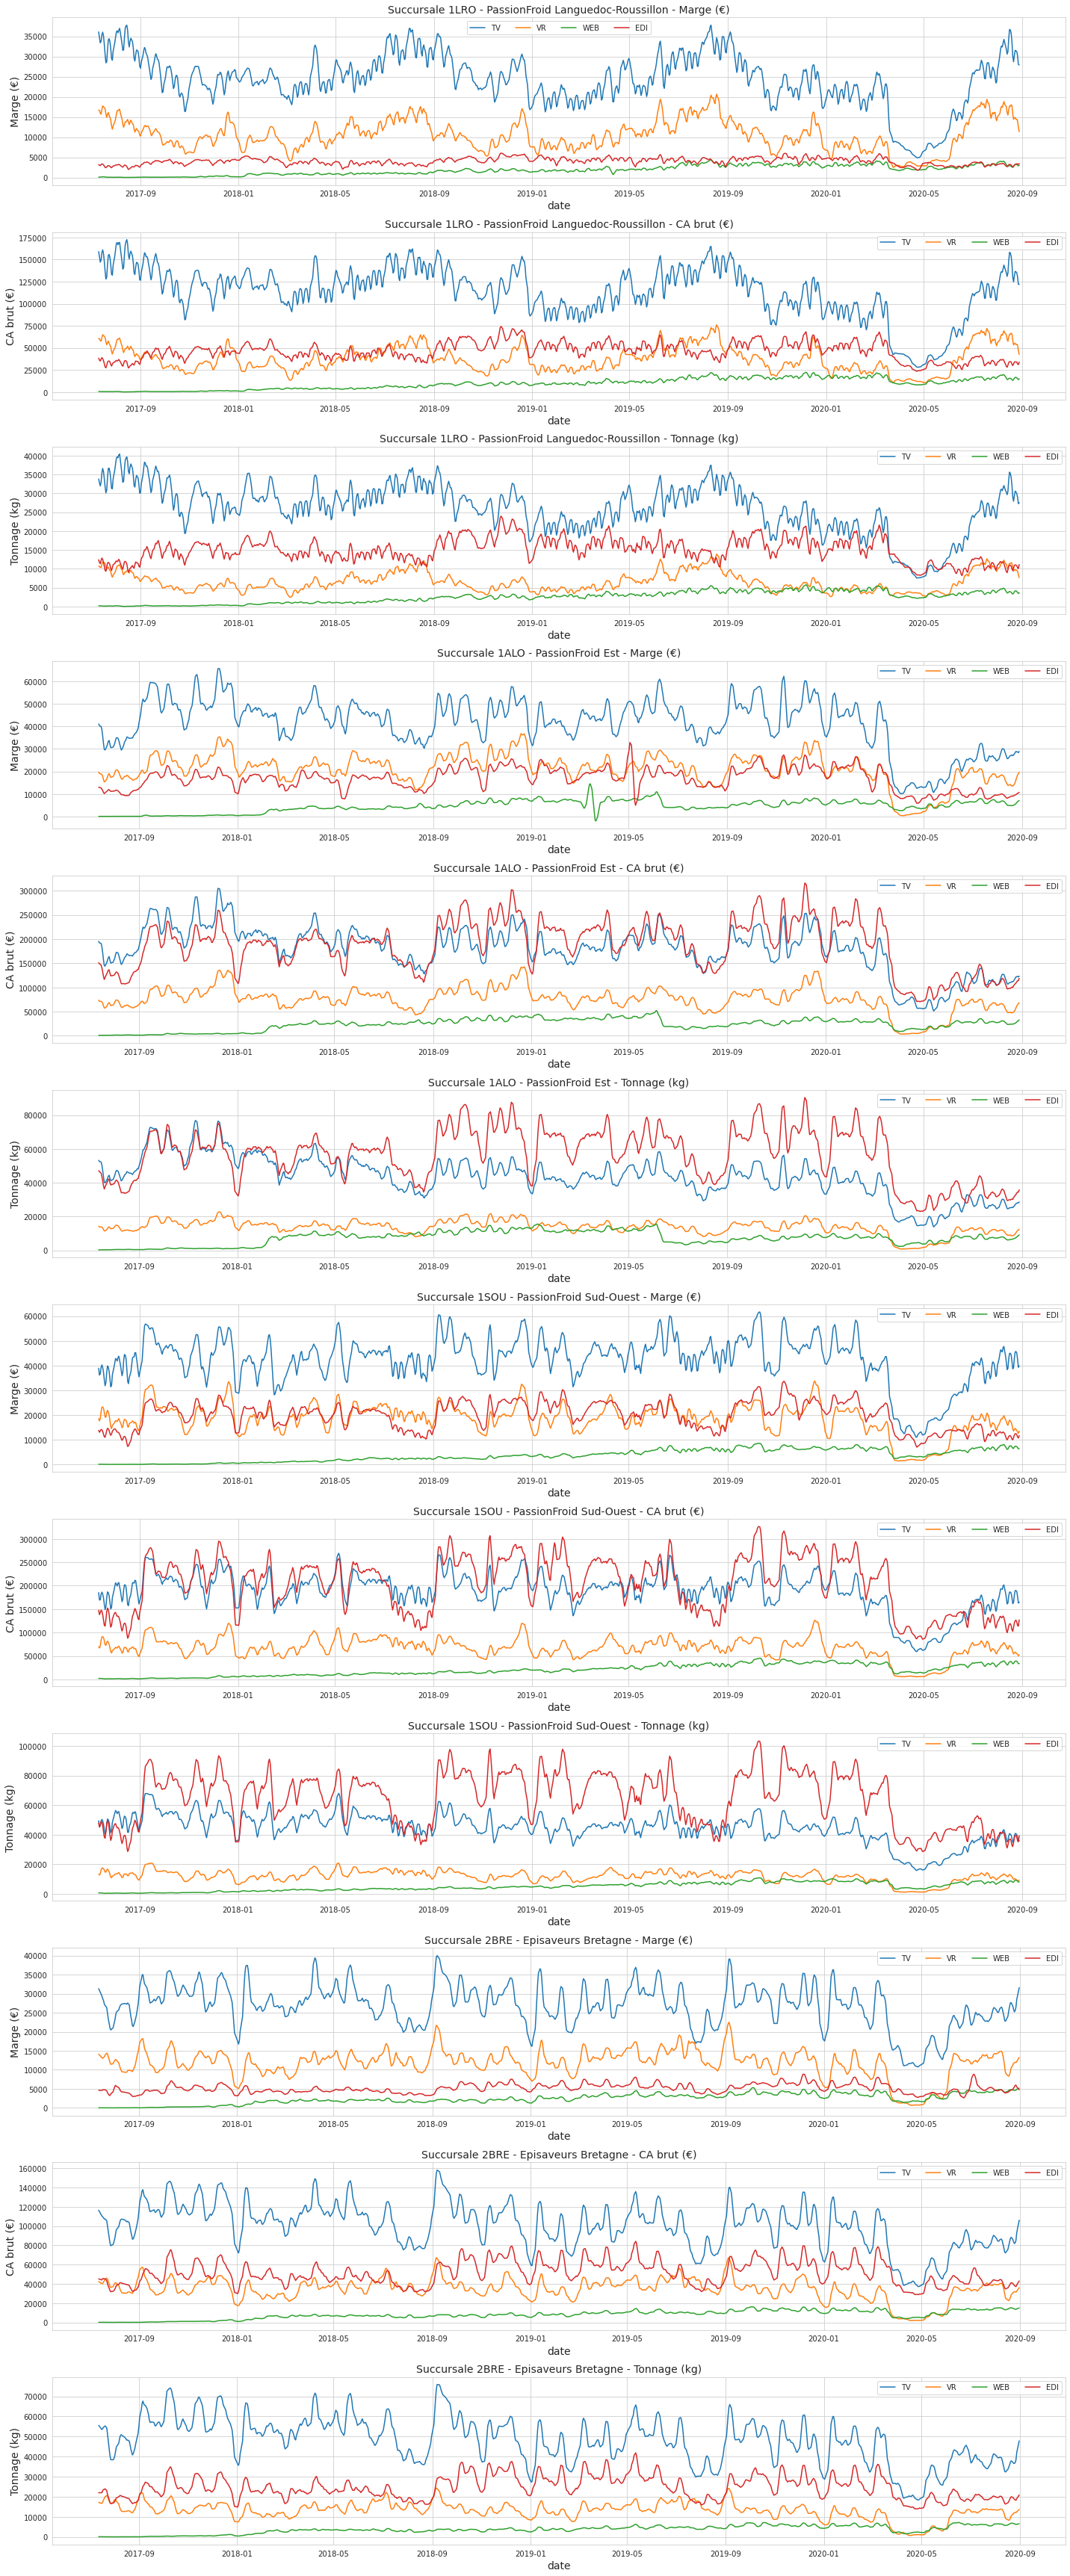

In [23]:
%%time
SV = data['orgacom'].unique()
indicators = ['weight', 'brutrevenue', 'margin']
roll_width = 10
win_type = 'triang'
fig, axs = plt.subplots(figsize=(20, 4 * len(SV)* len(indicator_map)),
                        nrows=len(SV) * len(indicator_map),
#                         squeeze=False,
                       )

for i, suc in enumerate(SV):
    for j, indicator in enumerate(indicator_map):
        
        data_to_plot = (
            data.loc[(data.orgacom == suc) & data.origin.isin(['TV', 'VR', 'WEB', 'EDI'])]
                .groupby(['date', 'origin'], observed=True)[indicator_map[indicator]]
                .sum()
                .unstack('origin')
                .fillna(0.)
                .rolling(roll_width, win_type=win_type)
                .mean()
                .stack('origin')
                .rename(indicator)
                .sort_index()
                .reset_index())
        sns.lineplot(data=data_to_plot,
                     x='date',
                     y=indicator,
                     hue='origin',
                     hue_order=mult_origins_order[:4],                     
                     ax=axs[i * len(indicator_map) + j])
        handles, labels = axs[i * len(indicator_map) + j].get_legend_handles_labels()
        handles = handles[1:]
        labels = labels[1:]
        axs[i * len(indicator_map) + j].legend(handles, labels, ncol=4, )
        axs[i * len(indicator_map) + j].set_title(f'Succursale {utils.lib(suc)} - {indicator}', fontsize=14)
        axs[i * len(indicator_map) + j].xaxis.label.set_fontsize(14)
        axs[i * len(indicator_map) + j].yaxis.label.set_fontsize(14)
        
fig.tight_layout()

## Filtration des canaux "exotiques"

In [24]:
origin2_cat = pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB'], ordered=True)
data['origin2'] = data.origin.astype(origin2_cat)

## Calcul du canal majoritaire par jour

In [25]:
aggfuncs = {
    'margin': 'sum', 
    'brutrevenue': 'sum',
    'weight': 'sum',
    'origin2': 'size',
}
orders = (
    data.loc[(data.doctype == 'ZC10') & (data.weight > 0.) & (data.brutrevenue > 0.)]
        .groupby(['orgacom', 'date', 'client', 'origin2'], observed=True)
        .agg(aggfuncs)
        .rename({'origin2': 'linecount'}, axis=1)
)
print(f'{len(orders)} records in order dataframe before canal deduplication')
orders

2751677 records in order dataframe before canal deduplication


margin  brutrevenue   weight  linecount
orgacom date       client     origin2                                         
1SOU    2017-07-03 0000065940 TV        31.16        84.01    5.501          9
                   0000065945 TV         6.02        23.69    3.734          2
                   0000065975 TV        25.15        97.40   13.718          1
                   0000065998 TV         4.12         8.56    1.000          1
                   0000066014 TV        17.89        48.30    5.000          1
...                                       ...          ...      ...        ...
2BRE    2020-08-31 0000285226 VR         1.38        10.16   10.000          2
                   SL001W     TV        89.34       555.25  180.000          4
                   SL0041     TV        28.42      1470.00    7.200          1
                   SL0075     TV        12.76        95.03   15.615         11
                   SL009N     TV        10.51        75.03   40.500          1

[2751677 rows x 4 columns]

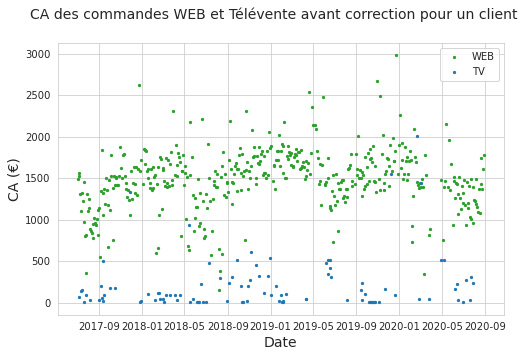

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[2],
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[0],
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('CA (€)', fontsize=14)
fig.suptitle('CA des commandes WEB et Télévente avant correction pour un client', fontsize=14)
ax.legend()


On considère le canal de la commande comme étant le canal qui représente le plus en poids pour un jour donné.

In [27]:
major_canal = orders['weight'].unstack(fill_value=0.).idxmax(axis=1).rename('origin2')
major_canal

orgacom  date        client    
1SOU     2017-07-03  0000065940     TV
                     0000065945     TV
                     0000065975     TV
                     0000065998     TV
                     0000066014     TV
                                  ... 
2BRE     2020-08-31  0000282373    EDI
                     0000283953    EDI
                     0000284089     TV
                     0000284540     TV
                     0000284735     VR
Name: origin2, Length: 2444326, dtype: object

In [28]:
orders = orders.groupby(level=[0, 1, 2], observed=True).sum().join(major_canal)
del(major_canal)
order_count = len(orders)
print(f'{order_count} records in order dataframe after canal deduplication')
orders

2444326 records in order dataframe after canal deduplication


margin  brutrevenue   weight  linecount origin2
orgacom date       client                                                     
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9      TV
                   0000065945    6.02        23.69    3.734          2      TV
                   0000065975   25.15        97.40   13.718          1      TV
                   0000065998    4.12         8.56    1.000          1      TV
                   0000066014   17.89        48.30    5.000          1      TV
...                               ...          ...      ...        ...     ...
2BRE    2020-08-31 0000285226  103.91       433.56   80.455         24      TV
                   SL001W       89.34       555.25  180.000          4      TV
                   SL0041       28.42      1470.00    7.200          1      TV
                   SL0075       12.76        95.03   15.615         11      TV
                   SL009N       10.51        75.03   40.500          1      TV

[2444326 rows x 5 columns]

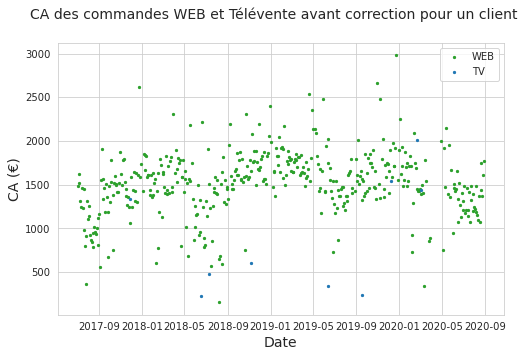

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[2],
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[0],
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('CA (€)', fontsize=14)
fig.suptitle('CA des commandes WEB et Télévente avant correction pour un client', fontsize=14)
ax.legend()


## Ajout de la segmentation et de la hiérarchie

On ajoute quelques données du dataset client.

In [30]:
clt_fields = ['seg1', 'seg2', 'seg3', 'seg4', 'cat', 'sscat', 'hier4']
for field in clt_fields:
    try:
        orders = orders.drop(field)
    except: 
        pass
orders = orders.merge(df_clt.loc[:, clt_fields], left_on=['orgacom', 'client'], right_index=True, validate='m:1')
if len(orders) != order_count:
    raise RuntimeError('Something went wrong when merging orders with client master data!')

In [31]:
orders

margin  brutrevenue   weight  linecount  \
orgacom date       client                                                
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9   
        2017-08-28 0000065940   44.36       105.93    8.048         10   
        2017-09-08 0000065940   17.60        40.35    3.000          2   
        2017-09-15 0000065940  100.12       236.77   20.312          3   
        2017-09-25 0000065940   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
2BRE    2020-08-31 0000282373  177.42      1401.58  488.036         88   
                   0000283953   43.79       421.67  564.980         28   
                   0000284089   89.39       186.75   90.200         12   
                   0000284540  262.04      1252.07  639.326         97   
                   0000284735  319.24       782.56  235.236         58   

                              origin2 seg1 seg2 seg3 seg4 cat sscat  hier4  
orgacom date       client                                                   
1SOU    2017-07-03 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-08-28 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-08 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-15 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-25 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
...                               ...  ...  ...  ...  ...  ..   ...    ...  
2BRE    2020-08-31 0000282373     EDI   Z3   Z4   ZJ   ZF  ZP    ZA  10705  
                   0000283953     EDI   Z3   Z4   ZJ   ZF  ZN   Z19  10506  
                   0000284089      TV   Z3   Z5   ZK   ZG  ZU   Z43    NaN  
                   0000284540      TV   Z3   Z4   ZJ   ZF  ZP    ZA  10432  
                   0000284735      VR   Z3   Z5   ZK   ZG  ZU    ZN    NaN  

[2444326 rows x 12 columns]

## Calcul des indicateurs composites

In [32]:
composite_indicators_dict = utils.composite_indicators_dict

for indicator, components in composite_indicators_dict.items():
    try:
        orders[indicator] = orders[components[0]] / orders[components[1]]
    except KeyError:
        pass

orders = orders.reset_index()
orders

orgacom       date      client  margin  brutrevenue   weight  \
0          1SOU 2017-07-03  0000065940   31.16        84.01    5.501   
1          1SOU 2017-08-28  0000065940   44.36       105.93    8.048   
2          1SOU 2017-09-08  0000065940   17.60        40.35    3.000   
3          1SOU 2017-09-15  0000065940  100.12       236.77   20.312   
4          1SOU 2017-09-25  0000065940   96.04       253.99   40.338   
...         ...        ...         ...     ...          ...      ...   
2444321    2BRE 2020-08-31  0000282373  177.42      1401.58  488.036   
2444322    2BRE 2020-08-31  0000283953   43.79       421.67  564.980   
2444323    2BRE 2020-08-31  0000284089   89.39       186.75   90.200   
2444324    2BRE 2020-08-31  0000284540  262.04      1252.07  639.326   
2444325    2BRE 2020-08-31  0000284735  319.24       782.56  235.236   

         linecount origin2 seg1 seg2 seg3 seg4 cat sscat  hier4       PMVK  \
0                9      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  15.271769   
1               10      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  13.162276   
2                2      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  13.450000   
3                3      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  11.656656   
4                5      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897   6.296544   
...            ...     ...  ...  ...  ...  ...  ..   ...    ...        ...   
2444321         88     EDI   Z3   Z4   ZJ   ZF  ZP    ZA  10705   2.871878   
2444322         28     EDI   Z3   Z4   ZJ   ZF  ZN   Z19  10506   0.746345   
2444323         12      TV   Z3   Z5   ZK   ZG  ZU   Z43    NaN   2.070399   
2444324         97      TV   Z3   Z4   ZJ   ZF  ZP    ZA  10432   1.958422   
2444325         58      VR   Z3   Z5   ZK   ZG  ZU    ZN    NaN   3.326702   

         marginperkg  marginpercent  lineweight  
0           5.664425       0.370908    0.611222  
1           5.511928       0.418767    0.804800  
2           5.866667       0.436183    1.500000  
3           4.929106       0.422858    6.770667  
4           2.380882       0.378125    8.067600  
...              ...            ...         ...  
2444321     0.363539       0.126586    5.545864  
2444322     0.077507       0.103849   20.177857  
2444323     0.991020       0.478661    7.516667  
2444324     0.409869       0.209285    6.590990  
2444325     1.357105       0.407943    4.055793  

[2444326 rows x 19 columns]

## Affichage des indicateurs sur l'année 2019

In [67]:
reload(utils)

<module 'scripts.utils' from '/home/pmasse/WebOrNot/scripts/utils.py'>

In [70]:
show(partial(utils.bk_histo_seg,
             source_df=orders.reset_index(),
             segs=['seg1', 'seg2'],
             filters={},
             filters_exclude={}, # 'hier4': ['198863']
             plot_kwargs=dict(title="Chiffre d'affaire brut 2019 en fonction de la segmentation niveau 2 et du canal"),
            ),
     notebook_url="http://devdm:8888")

In [71]:
show(partial(utils.bk_histo_seg,
             source_df=orders.reset_index(),
             segs=['seg2', 'seg3'],
             filters={'seg1': ['Z3']},
             filters_exclude={}, #'hier4': ['198863']
             plot_kwargs=dict(title="Chiffre d'affaire brut 2019 en fonction de la segmentation niveau 3 et du canal"),
            ),
     notebook_url="http://devdm:8888") #'seg1': ['Z3']

## Affichage des distributions - par succursale

In [35]:
filter_otacos = (orders.hier4 != '198863')

CPU times: user 54 s, sys: 21.1 s, total: 1min 15s
Wall time: 43.9 s


Text(0.5, 0.91, 'Analyse des commandes par succursale')

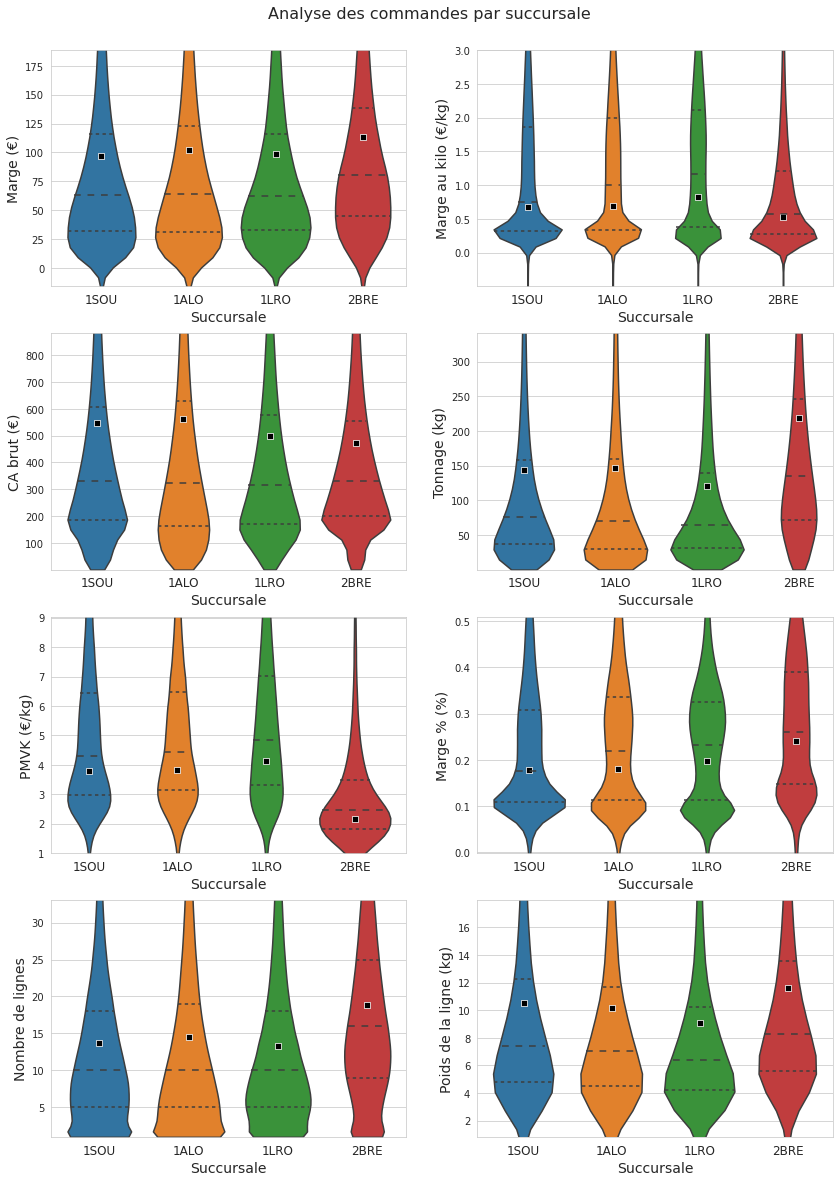

In [36]:
%%time
indicators2 = ['margin', 'brutrevenue',  'PMVK', 'linecount', 'marginperkg', 'weight', 'marginpercent', 'lineweight']
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue=None,
                              hue_order=None,
                              translate=['xaxis', 'indicator',],                              
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par succursale', fontsize=16, y=.91)

In [37]:
utils.pretty_means(data=orders.reset_index(), groupers=['orgacom'], indicators=indicators2)

## Affichage des distributions - par canal de vente

CPU times: user 52 s, sys: 21.3 s, total: 1min 13s
Wall time: 41.9 s


Text(0.5, 0.91, 'Analyse des commandes par canal')

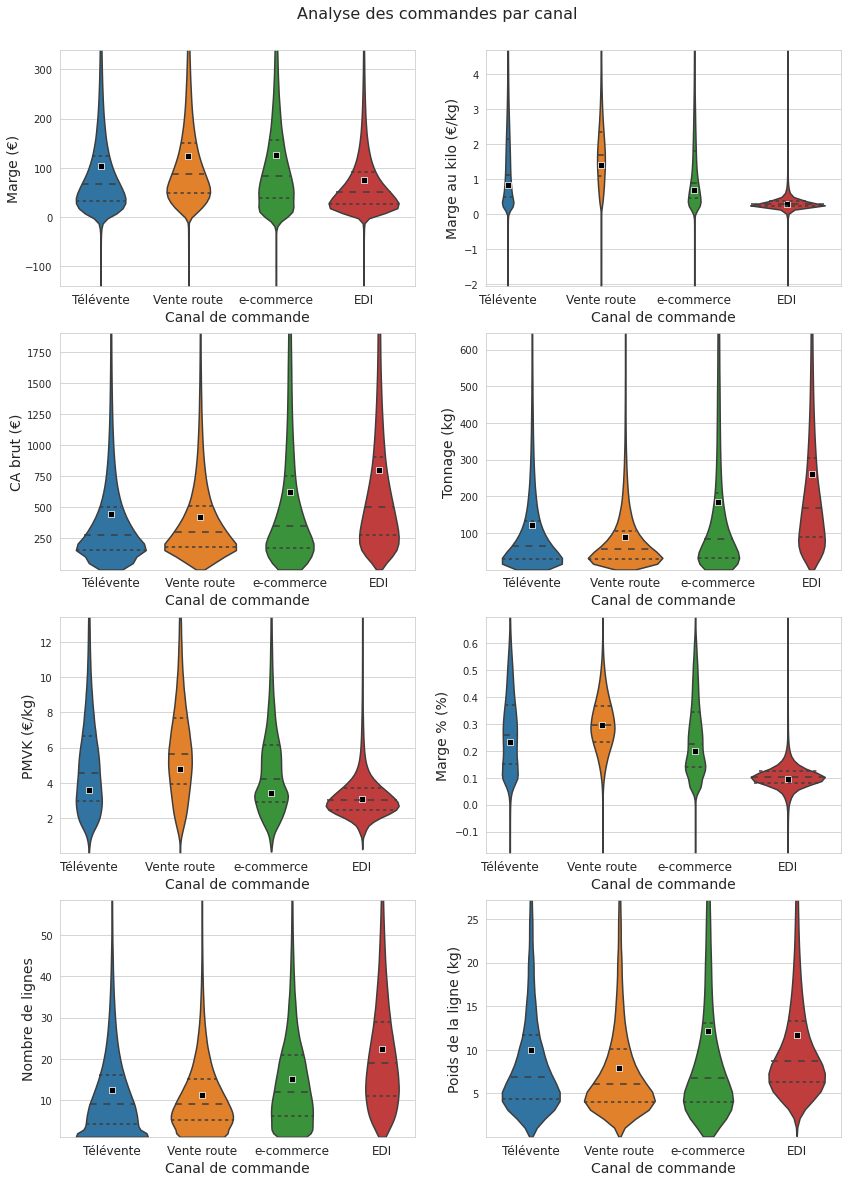

In [38]:
%%time
fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=True,
                              hue=None,
                              hue_order=None,
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)

In [39]:
utils.pretty_means(data=orders.reset_index(),
                   groupers=['origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente - hors O'Tacos

CPU times: user 51.9 s, sys: 21.6 s, total: 1min 13s
Wall time: 42.3 s


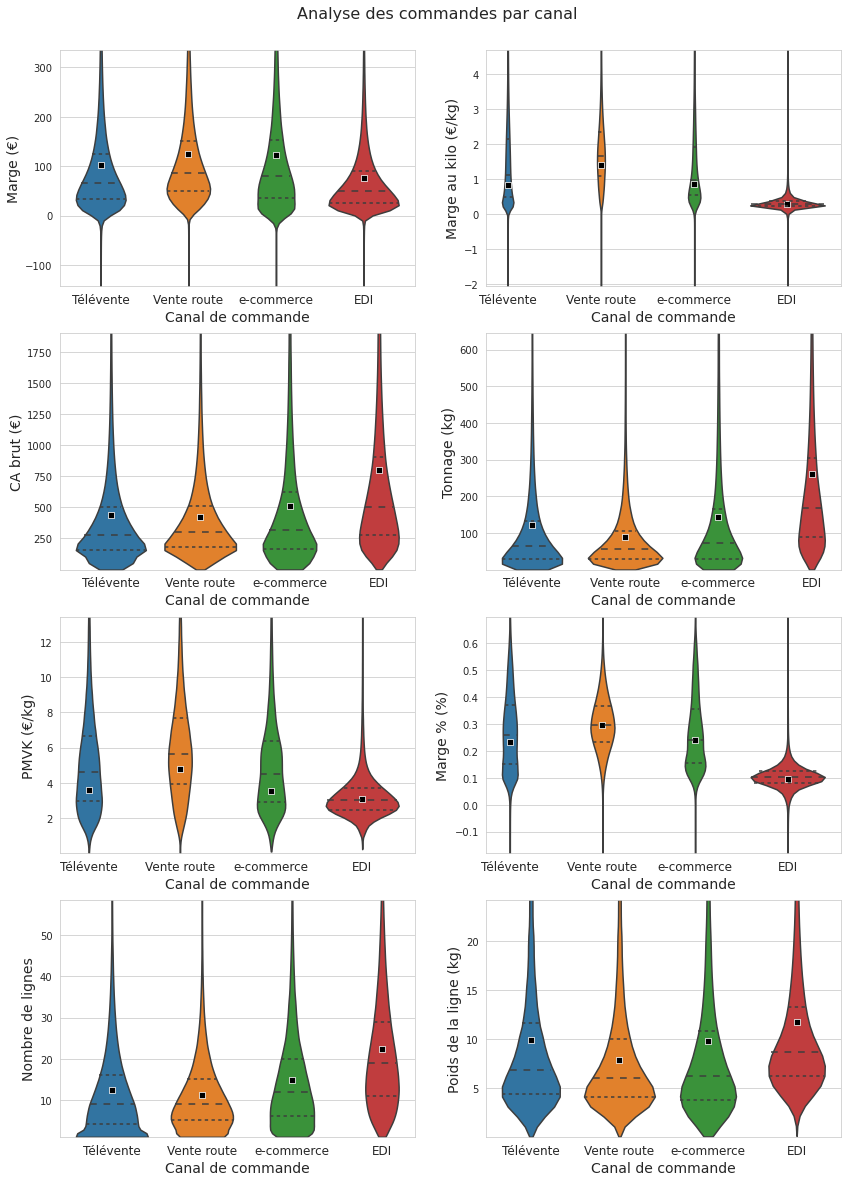

In [40]:
%%time
fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=filter_otacos,
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=True,
                              hue=None,
                              hue_order=None,
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[filter_otacos].reset_index(),
                   groupers=['origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente - uniquement O'Tacos

CPU times: user 708 ms, sys: 75.7 ms, total: 784 ms
Wall time: 782 ms


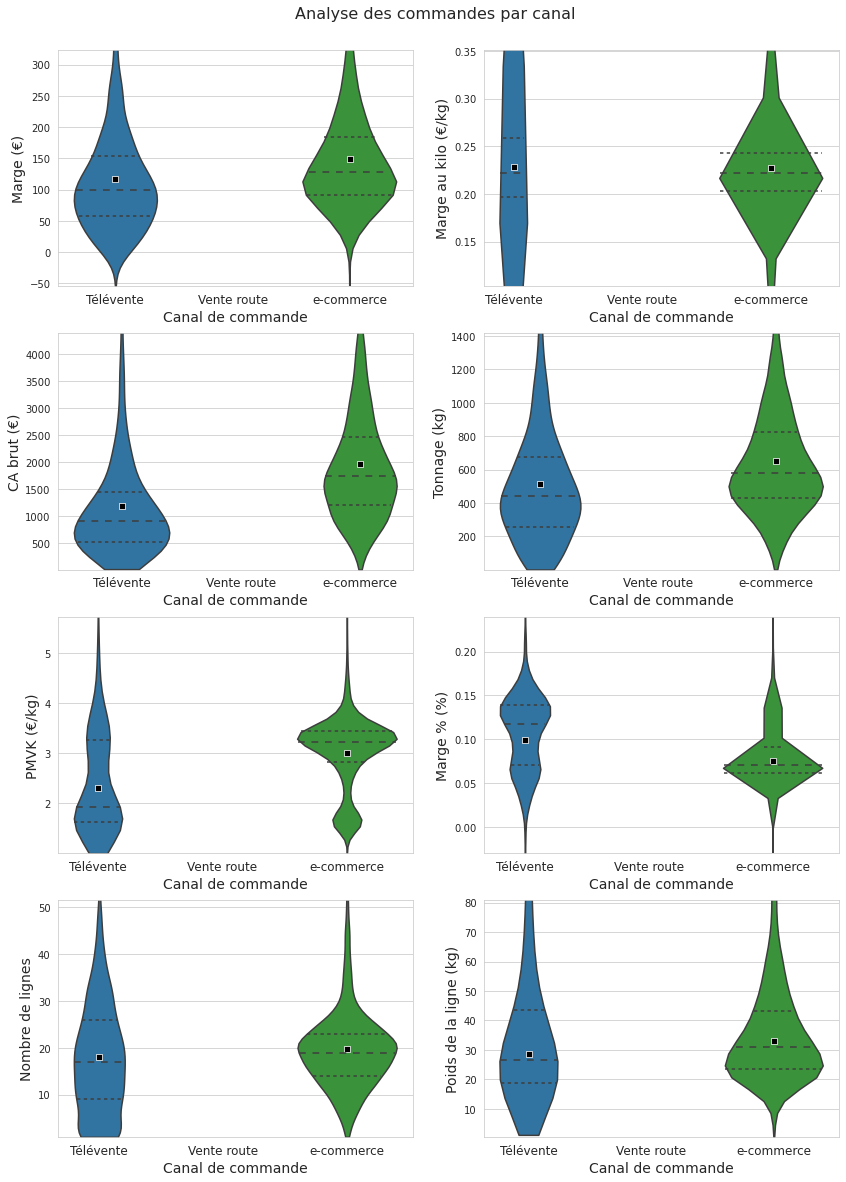

In [41]:
%%time
fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=(~filter_otacos) & (orders.origin2 != 'VR'),
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=True,
                              hue=None,
                              hue_order=None,
                              kind='violin',
                              percentile_selection=1.,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[~filter_otacos].reset_index(),
                   groupers=['origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente et succursale

/home/pmasse/WebOrNot/scripts/utils.py:465: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


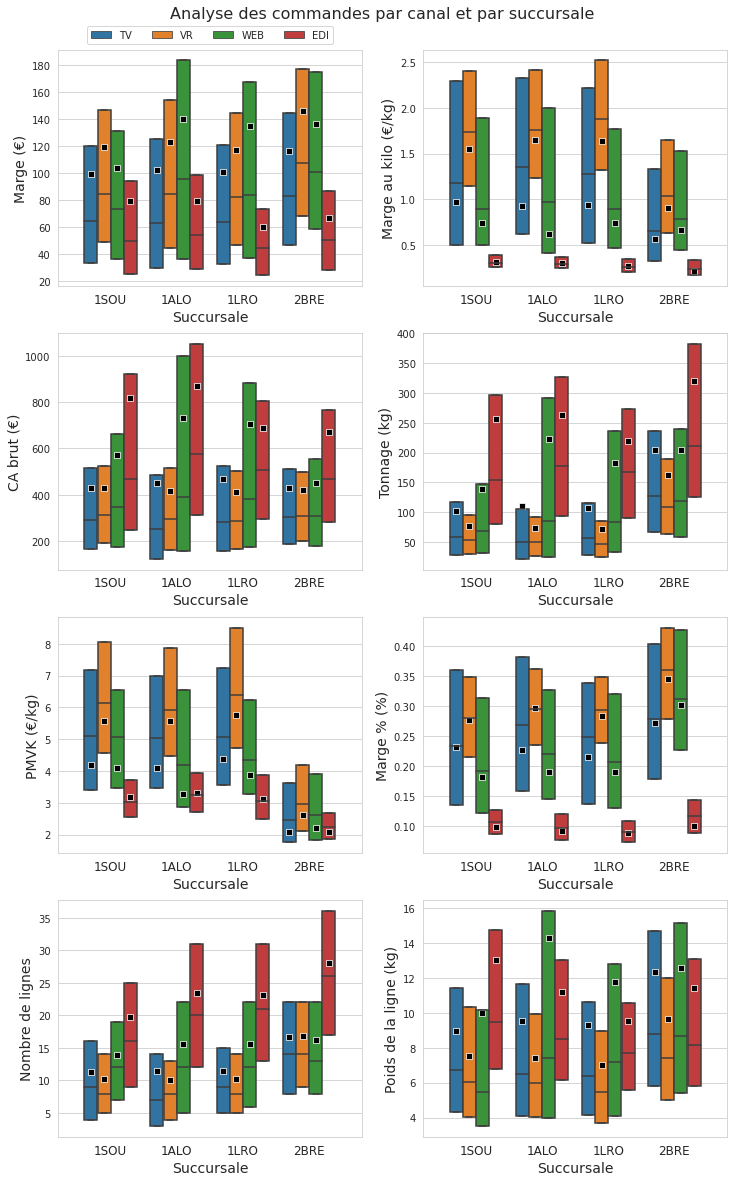

In [42]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator',],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=None,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle('Analyse des commandes par canal et par succursale', fontsize=16, y=.91)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
utils.pretty_means(data=orders.reset_index(),
                   groupers=['orgacom', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par segment

In [151]:
def translate(df):
    df['seg3'] = df['seg3'].map(utils.transco['seg3'])
    return(df)

TypeError: 'Styler' object is not subscriptable

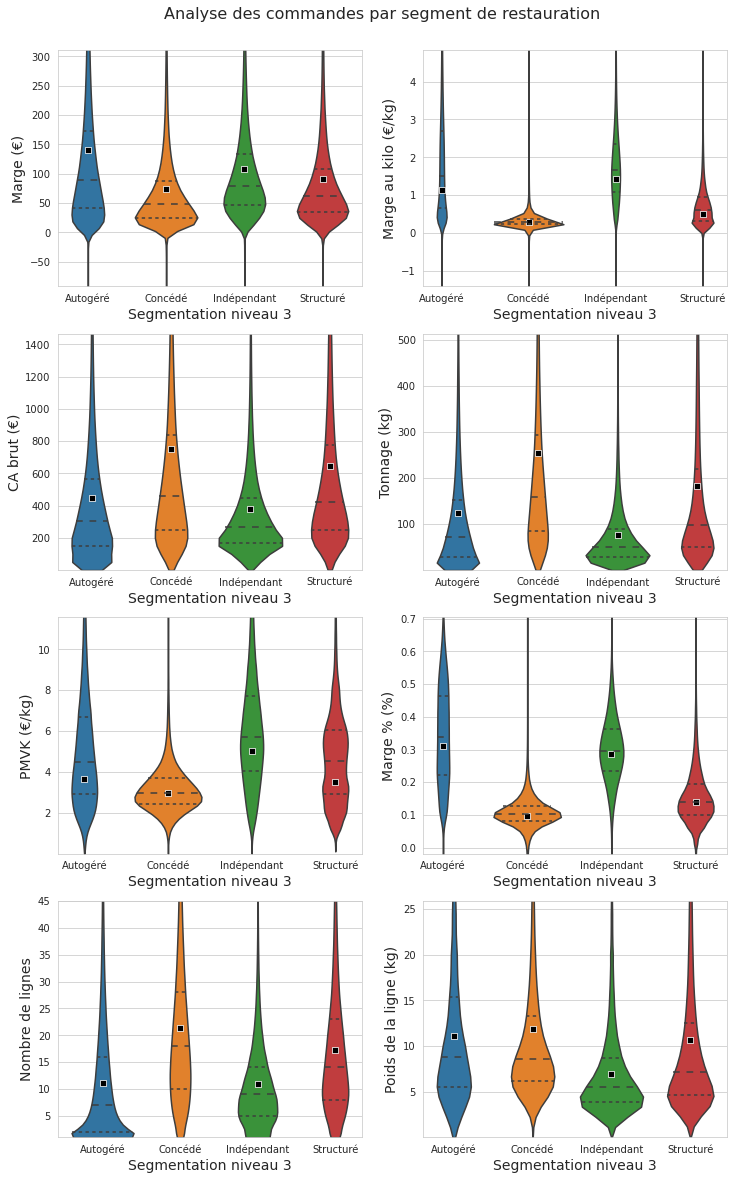

In [147]:
filter_rhd = (orders.seg1 == 'Z3')
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rhd),
                              ncols=2,
#                               hue='origin2',
#                               hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par segment de restauration", fontsize=16, y=.91)
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
# for ax_list in axs:
#     for ax in ax_list:
#         ax.get_legend().remove()


In [155]:
utils.pretty_means(data=orders[filter_rhd].reset_index(),
                   groupers=['seg3'],
                   indicators=indicators2,
                   translate=['columns', 'seg3']
                  )

In [152]:

display(utils.compute_means(data=orders.loc[filter_rhd & filter_otacos].reset_index(),
                            groupers=['seg3'],
                            indicators=indicators2)
             .reset_index()
             .pipe(translate)
             .sort_values('seg3')
             .set_index(['seg3'])
             .style.format(formats)
       )

## Impact du Web sur les indicateurs, à la maille du client

On calcule le zscore sur les indicateurs suivis, **à la maille du client DO**.

In [45]:
orders = compute_zscores(orders,
                         grouper_fields=['orgacom', 'client'],
                         indicators=indicators2)

margin done!
brutrevenue done!
PMVK done!
linecount done!
marginperkg done!
weight done!
marginpercent done!
lineweight done!
ALL DONE!


Pour un client donné, cela ne change pas le rapport entre les divers indicateurs :

In [46]:
sample = orders.reset_index().loc[orders.reset_index().origin2 == 'WEB'].sample(1).iloc[0]

0000067029 - TUTTI PIZZA AUCAMVILLE


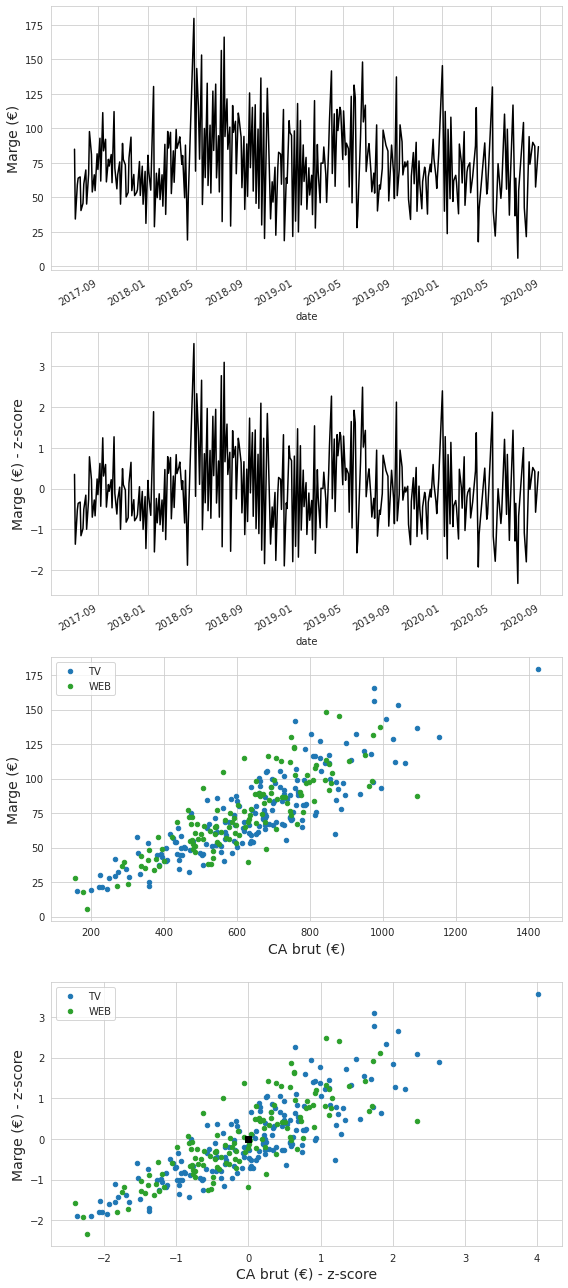

In [47]:
oc, client = '1SOU', '0000067029' #sample.orgacom, sample.client
name = df_clt.loc[(oc, client), 'nom']
print(f'{client} - {name}')
fig, axs = plt.subplots(figsize=(8, 18), nrows=4)
mask_clt = (orders.reset_index().client == client)
mask_web = mask_clt & (orders.reset_index().origin2 == 'WEB')
mask_other = mask_clt & (orders.reset_index().origin2 != 'WEB')
col_web = list(mcolor.TABLEAU_COLORS.values())[2]
col_tv = list(mcolor.TABLEAU_COLORS.values())[0]
(orders.reset_index()
       .loc[mask_other]
       .rename({'margin': 'Marge (€)',
                'brutrevenue': 'CA brut (€)'}, axis=1)
       .plot(kind='scatter', y='Marge (€)', x='CA brut (€)', color=col_tv, ax=axs[2], label='TV')
)
(orders.reset_index()
       .loc[mask_web]
       .rename({'margin': 'Marge (€)',
                'brutrevenue': 'CA brut (€)'}, axis=1)
       .plot(kind='scatter', y='Marge (€)', x='CA brut (€)', color=col_web, ax=axs[2], label='WEB')
)

(orders.reset_index()
       .loc[mask_other]
       .rename({'margin_clt_zscore': 'Marge (€) - z-score',
                'brutrevenue_clt_zscore': 'CA brut (€) - z-score'}, axis=1)
       .plot(kind='scatter', y='Marge (€) - z-score', x='CA brut (€) - z-score', color=col_tv, ax=axs[3], label='TV')
)
(orders.reset_index()
       .loc[mask_web]
       .rename({'margin_clt_zscore': 'Marge (€) - z-score',
                'brutrevenue_clt_zscore': 'CA brut (€) - z-score'}, axis=1)
       .plot(kind='scatter', y='Marge (€) - z-score', x='CA brut (€) - z-score', color=col_web, ax=axs[3], label='WEB')
)

axs[3].scatter(x=[0], y=[0], marker='s', color='black')
orders.reset_index().loc[mask_clt].plot(kind='line', y='margin', x='date', color='black', ax=axs[0])
orders.reset_index().loc[mask_clt].plot(kind='line', y='margin_clt_zscore', x='date', color='black', ax=axs[1])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[0].set_ylabel('Marge (€)', fontsize=14)
axs[1].set_ylabel('Marge (€) - z-score', fontsize=14)
axs[2].set_ylabel('Marge (€)', fontsize=14)
axs[3].set_ylabel('Marge (€) - z-score', fontsize=14)
axs[2].set_xlabel('CA brut (€)', fontsize=14)
axs[3].set_xlabel('CA brut (€) - z-score', fontsize=14)
axs[2].legend()
axs[3].legend()
fig.tight_layout()

### Création d'un exemple fictif

On crée un exemple fictif pour illustrer.

In [48]:
def dt_linspace(start, end, n):
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    t = np.linspace(start.value, end.value, n)
    t = pd.to_datetime(t)
    return(t)
t1 = dt_linspace('2019-01-01', '2019-03-31', 10)
type(t1)

pandas.core.indexes.datetimes.DatetimeIndex

In [49]:
np.random.normal(size=20) + [10] * 20

array([ 9.23694151, 10.20312202,  9.62652233, 11.81491229,  9.17581513,
        8.95645167, 10.74836707, 11.31765237,  9.30912341,  8.6288304 ,
       10.8852024 , 10.75218236, 10.69796548, 10.44170135,  8.69118735,
        8.94664352, 10.19066197, 10.64287708,  9.42830906,  9.99400799])

In [50]:
palette = [
    list(mcolor.TABLEAU_COLORS.values())[0],
    list(mcolor.TABLEAU_COLORS.values())[2],
]

len_clt1 = 50
clt1_origin = ['TV'] * len_clt1
web_clt1_indices = [12, 36]
for idx_ in web_clt1_indices:
    clt1_origin[idx_] = 'WEB'


ex_df = [
    pd.DataFrame(
        {
            'client': ['clt1'] * len_clt1,
            'date': dt_linspace('2019-01-01', '2019-03-31',len_clt1),
            'origin': clt1_origin,
            'margin': np.random.normal(size=len_clt1) + [10] * len_clt1,
        }
    ),
    pd.DataFrame(
        {
            'client': ['clt2'] * 15,
            'date': dt_linspace('2019-01-01', '2019-03-22', 15),
            'origin': ['TV'] * 7 + ['WEB'] * 8,
            'margin': np.random.normal(size=15) + ([25] * 7 + [20] * 8),
        }
    )
]
ex_df = pd.concat(ex_df)
ex_df = utils.compute_zscores(ex_df, indicators=['margin'], grouper_fields=['client'])
# sns.scatterplot(data=ex_df, x='date', y='margin', hue=ex_df.origin.to_list(),
#                 palette=palette,
#                 style=ex_df.origin.to_list(),
#                )

margin done!
ALL DONE!


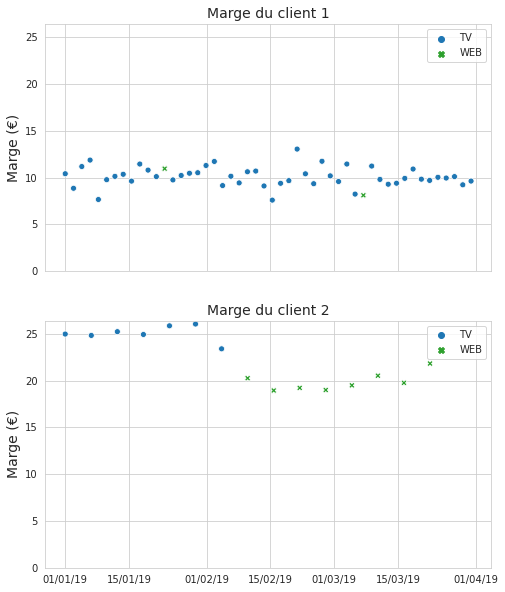

In [51]:
fig, axs = plt.subplots(nrows=2, figsize=(8,10), sharex=True)
to_plot = ex_df.loc[ex_df.client == 'clt1']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[0],
               )
to_plot = ex_df.loc[ex_df.client == 'clt2']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[1],
               )
axs[1].set_ylim(0)
axs[0].set_ylim(0, axs[1].get_ylim()[1])
axs[0].set_title('Marge du client 1', fontsize=14)
axs[1].set_title('Marge du client 2', fontsize=14)
axs[1].set_xlabel(None)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
for ax in axs:
    ax.set_ylabel('Marge (€)', fontsize=14)

Text(0, 0.5, 'Marge (€)')

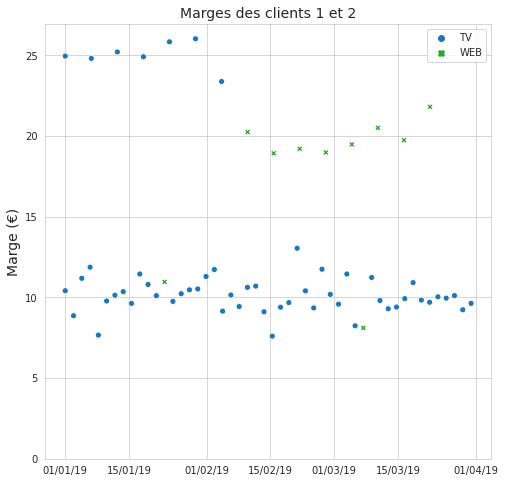

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
to_plot = ex_df
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=ax,
               )
ax.set_title('Marges des clients 1 et 2', fontsize=14)
ax.set_xlabel(None)
ax.set_ylim(0)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
ax.set_ylabel('Marge (€)', fontsize=14)

<AxesSubplot:xlabel='Canal de commande', ylabel='Marge (€) - z-score'>

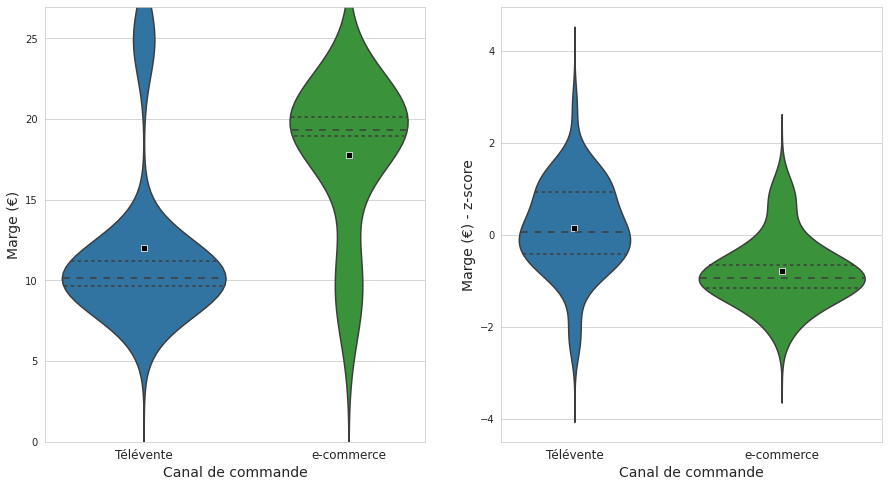

In [53]:
fig, axs = utils.plot_distrib(
    data=ex_df, 
    ncols=2,
    indicators=['margin', 'margin_clt_zscore'],
    x='origin',
    order=['TV', 'WEB'],
    kind='violin',
    percentile_selection=0.99,
    IQR_factor_selection=3.0,
    IQR_factor_plot=None,
    show_means=True,
    plot_kwargs=dict(palette=palette, cut=4.),
    translate=True,
    fontsizes_kwargs=None,    
)
axs[0, 0].set_ylim(0, ax.get_ylim()[1])
axs[0, 1]

In [54]:
utils.pretty_means(data=ex_df,
                   groupers=['origin'],
                   indicators=['margin', 'margin_clt_zscore'],
                   translate=['columns', 'origin']
                  )

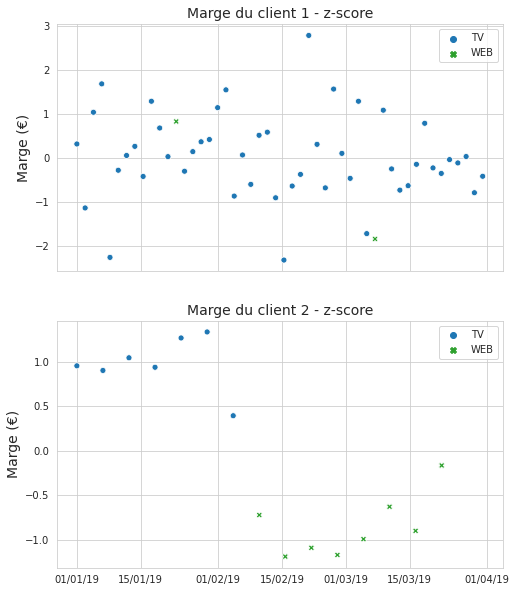

In [55]:
fig, axs = plt.subplots(nrows=2, figsize=(8,10), sharex=True)
to_plot = ex_df.loc[ex_df.client == 'clt1']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[0],
               )
to_plot = ex_df.loc[ex_df.client == 'clt2']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[1],
               )
axs[0].set_title('Marge du client 1 - z-score', fontsize=14)
axs[1].set_title('Marge du client 2 - z-score', fontsize=14)
axs[1].set_xlabel(None)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
for ax in axs:
    ax.set_ylabel('Marge (€)', fontsize=14)

Text(0, 0.5, 'Marge (€) - z-score')

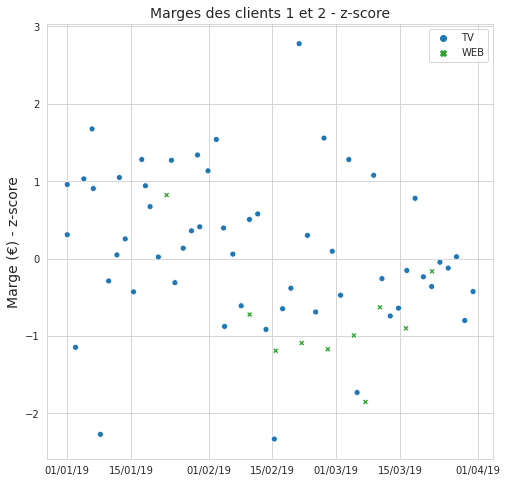

In [56]:
fig, ax = plt.subplots(figsize=(8, 8))
to_plot = ex_df
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=ax,
               )
ax.set_title('Marges des clients 1 et 2 - z-score', fontsize=14)
ax.set_xlabel(None)
# ax.set_ylim(0)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
ax.set_ylabel('Marge (€) - z-score', fontsize=14)

<AxesSubplot:xlabel='brutrevenue_clt_zscore', ylabel='margin_clt_zscore'>

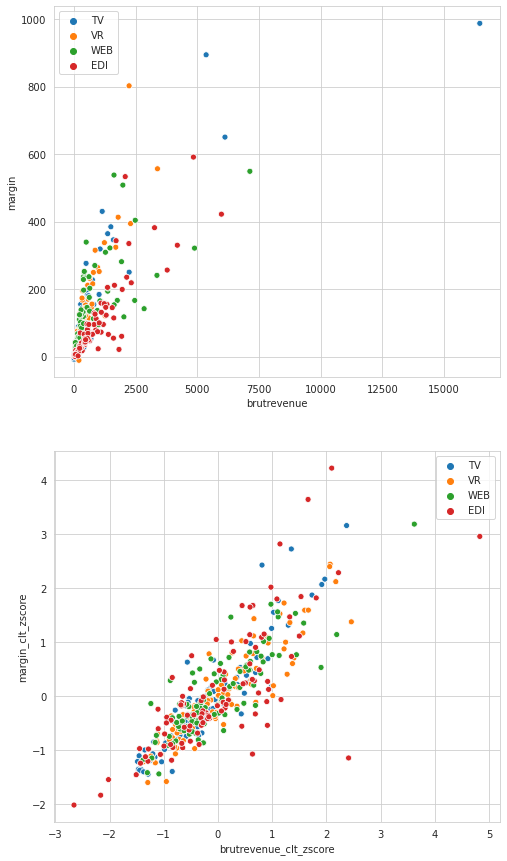

In [57]:
df_sample = pd.concat([orders.loc[orders.origin2 == origin].sample(100) for origin in orders.origin2.unique()], axis=0)

fig, axs = plt.subplots(nrows=2, figsize=(8, 15))
sns.scatterplot(data=df_sample, x='brutrevenue', y='margin', hue=df_sample.origin2.tolist(), ax=axs[0])
sns.scatterplot(data=df_sample, x='brutrevenue_clt_zscore', y='margin_clt_zscore', hue=df_sample.origin2.tolist(), ax=axs[1])

## Affichage des indicateurs en zscore par canal

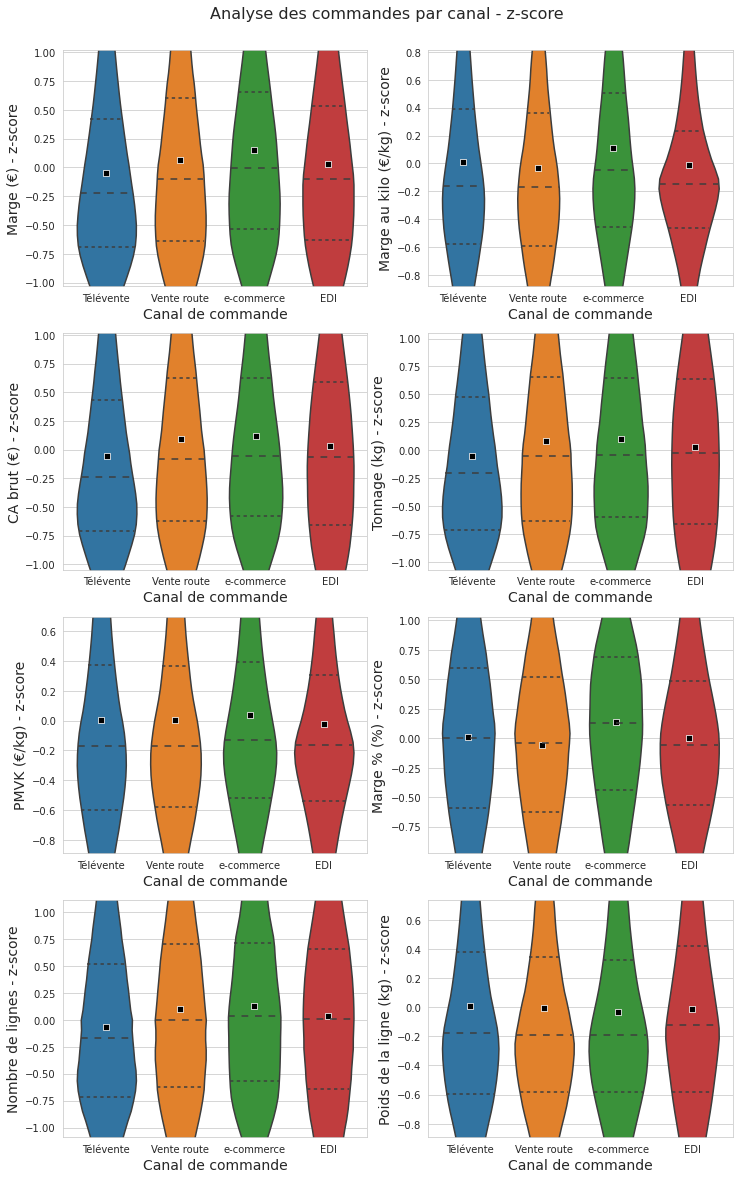

In [58]:
indicators_zscore = [indicator + '_clt_zscore' for indicator in indicators2]

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              hue=None,
                              hue_order=None,
                              x='origin2',
                              order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.3,
                              show_means=True,
                              plot_kwargs=dict(whis=1.5),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - z-score", fontsize=16, y=.91)

utils.pretty_means(data=orders.reset_index(),
                   groupers=['origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'origin2']
                  )

## Affichage des indicateurs en zscore par canal et succursale

/home/pmasse/WebOrNot/scripts/utils.py:465: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


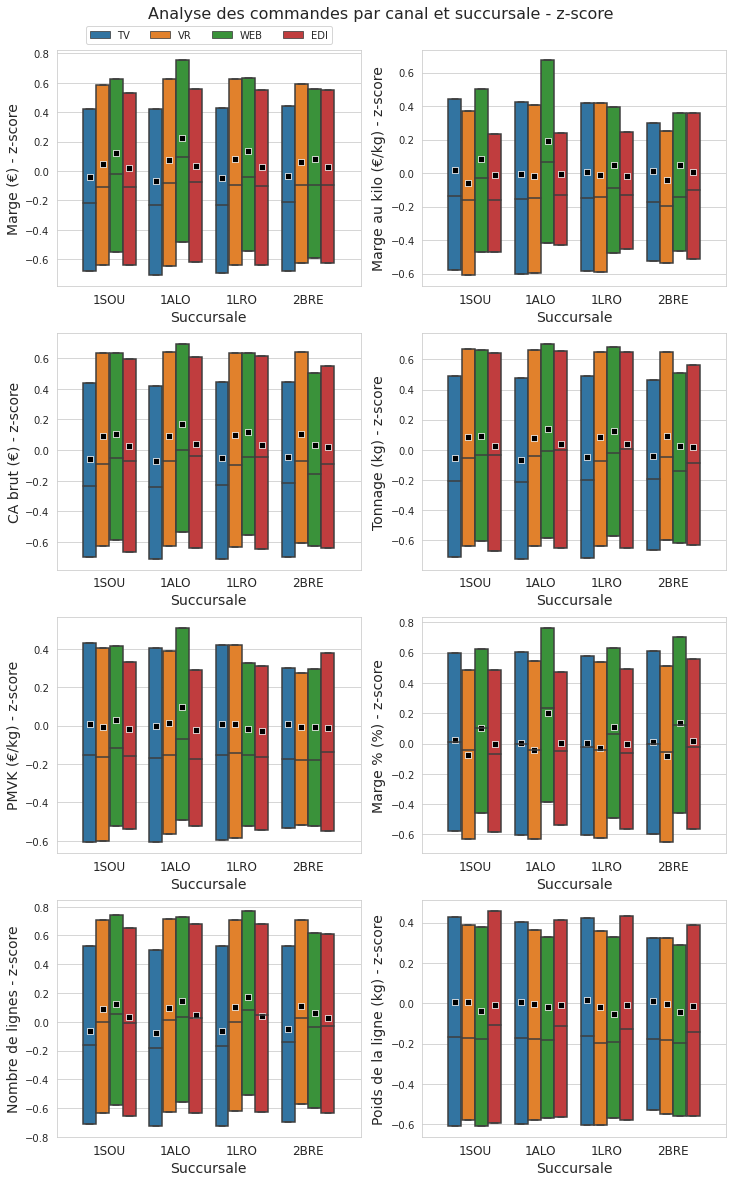

In [59]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', ],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et succursale - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

utils.pretty_means(data=orders.reset_index(),
                   groupers=['orgacom', 'origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'origin2']
                  )

## Affichage des indicateurs en zscore par canal et par segment

/home/pmasse/WebOrNot/scripts/utils.py:465: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


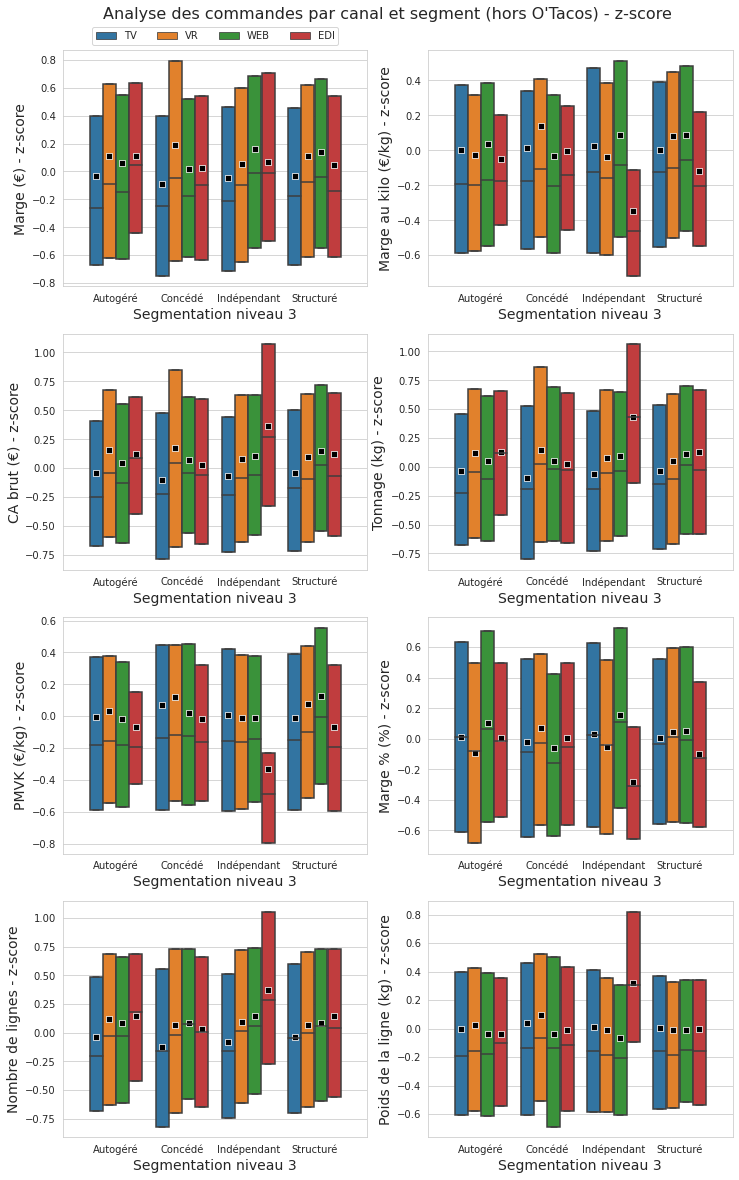

In [60]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=(filter_otacos),
                              ncols=2,
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et segment (hors O'Tacos) - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
        

In [61]:
display(utils.compute_means(data=orders.loc[filter_otacos & filter_rhd].reset_index(),
                            groupers=['seg3', 'origin2'],
                            indicators=indicators_zscore)
             .reset_index()
             .pipe(translate)
             .sort_values('seg3')
             .set_index(['seg3', 'origin2'])
#              .style.format(formats)
       )

size  margin_clt_zscore  brutrevenue_clt_zscore  \
seg3        origin2                                                      
Autogéré    TV       414707          -0.031124               -0.039471   
            VR        96462           0.112217                0.154593   
            WEB       31749           0.061664                0.041534   
            EDI        1141           0.109374                0.120942   
Concédé     TV       153189          -0.092008               -0.099813   
            VR         1292           0.189041                0.178287   
            WEB        1496           0.014899                0.074219   
            EDI      573131           0.024127                0.026083   
Indépendant TV       454259          -0.048120               -0.066849   
            VR       352200           0.051013                0.078752   
            WEB       24270           0.159921                0.105834   
            EDI         168           0.064775                0.367486   
Structuré   TV       159035          -0.029466               -0.040620   
            VR        11609           0.107613                0.095948   
            WEB       17275           0.137123                0.151604   
            EDI       22143           0.048233                0.123164   

                     PMVK_clt_zscore  linecount_clt_zscore  \
seg3        origin2                                          
Autogéré    TV             -0.005329             -0.034601   
            VR              0.029418              0.120020   
            WEB            -0.017828              0.082029   
            EDI            -0.065289              0.146731   
Concédé     TV              0.068158             -0.122339   
            VR              0.122235              0.066212   
            WEB             0.019895              0.086621   
            EDI            -0.018536              0.032324   
Indépendant TV              0.007089             -0.080039   
            VR             -0.008266              0.092693   
            WEB            -0.010561              0.150349   
            EDI            -0.330449              0.375259   
Structuré   TV             -0.009700             -0.035026   
            VR              0.074817              0.071980   
            WEB             0.125304              0.088790   
            EDI            -0.067136              0.144558   

                     marginperkg_clt_zscore  weight_clt_zscore  \
seg3        origin2                                              
Autogéré    TV                     0.004172          -0.032308   
            VR                    -0.029014           0.119453   
            WEB                    0.035543           0.054349   
            EDI                   -0.052444           0.131623   
Concédé     TV                     0.015312          -0.098355   
            VR                     0.138013           0.143493   
            WEB                   -0.031549           0.049879   
            EDI                   -0.004321           0.025835   
Indépendant TV                     0.025521          -0.063763   
            VR                    -0.038752           0.075646   
            WEB                    0.087068           0.092713   
            EDI                   -0.344524           0.430871   
Structuré   TV                     0.000669          -0.033793   
            VR                     0.080308           0.052687   
            WEB                    0.088765           0.107555   
            EDI                   -0.116159           0.131172   

                     marginpercent_clt_zscore  lineweight_clt_zscore  
seg3        origin2                                                   
Autogéré    TV                       0.013510              -0.003603  
            VR                      -0.091429               0.028183  
            WEB                      0.101020              -0.037092  
            EDI              

## Affichage des indicateurs en zscore par canal et par segment - hors EDI et SDR

**ATTENTION !!!** Cet indicateur devrait être recalculé, car la filtration du canal EDI filtre une partie des commandes d'un client et donc le zscore n'est plus bon.

/home/pmasse/WebOrNot/scripts/utils.py:465: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


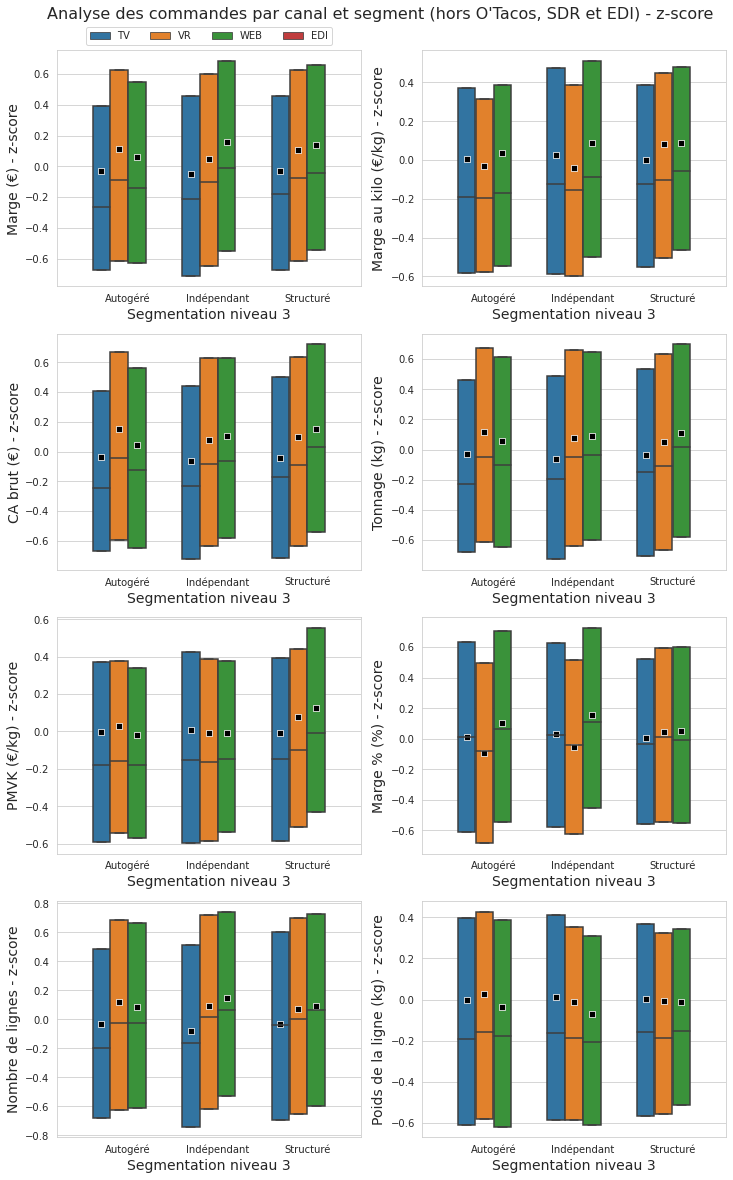

In [62]:
filter_not_edi = ~orders.origin2.isin(['EDI'])
filter_not_sdr = ~orders.seg3.isin(['ZJ'])

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=(filter_otacos & filter_not_edi & filter_not_sdr & filter_rhd),
                              ncols=2,
                              x='seg3',
                              order=['ZI', 'ZK', 'ZL'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et segment (hors O'Tacos, SDR et EDI) - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
        

In [63]:
display(utils.compute_means(data=orders.loc[filter_otacos & filter_rhd & filter_not_edi & filter_not_sdr].reset_index(),
                            groupers=['seg3', 'origin2'],
                            indicators=indicators_zscore)
             .reset_index()
             .pipe(translate)
             .sort_values('seg3')
             .set_index(['seg3', 'origin2'])
#              .style.format(formats)
       )

size  margin_clt_zscore  brutrevenue_clt_zscore  \
seg3        origin2                                                      
Autogéré    TV       414707          -0.031124               -0.039471   
            VR        96462           0.112217                0.154593   
            WEB       31749           0.061664                0.041534   
Indépendant TV       454259          -0.048120               -0.066849   
            VR       352200           0.051013                0.078752   
            WEB       24270           0.159921                0.105834   
Structuré   TV       159035          -0.029466               -0.040620   
            VR        11609           0.107613                0.095948   
            WEB       17275           0.137123                0.151604   

                     PMVK_clt_zscore  linecount_clt_zscore  \
seg3        origin2                                          
Autogéré    TV             -0.005329             -0.034601   
            VR              0.029418              0.120020   
            WEB            -0.017828              0.082029   
Indépendant TV              0.007089             -0.080039   
            VR             -0.008266              0.092693   
            WEB            -0.010561              0.150349   
Structuré   TV             -0.009700             -0.035026   
            VR              0.074817              0.071980   
            WEB             0.125304              0.088790   

                     marginperkg_clt_zscore  weight_clt_zscore  \
seg3        origin2                                              
Autogéré    TV                     0.004172          -0.032308   
            VR                    -0.029014           0.119453   
            WEB                    0.035543           0.054349   
Indépendant TV                     0.025521          -0.063763   
            VR                    -0.038752           0.075646   
            WEB                    0.087068           0.092713   
Structuré   TV                     0.000669          -0.033793   
            VR                     0.080308           0.052687   
            WEB                    0.088765           0.107555   

                     marginpercent_clt_zscore  lineweight_clt_zscore  
seg3        origin2                                                   
Autogéré    TV                       0.013510              -0.003603  
            VR                      -0.091429               0.028183  
            WEB                      0.101020              -0.037092  
Indépendant TV                       0.034006               0.013403  
            VR                      -0.054317              -0.012693  
            WEB                      0.153694              -0.068870  
Structuré   TV                       0.004695               0.002277  
            VR                       0.041407              -0.007736  
            WEB                      0.053421              -0.011700

## Liens avec la segmentation

In [64]:
orders#.loc[filter_rhd]

orgacom       date      client  margin  brutrevenue   weight  \
0          1SOU 2017-07-03  0000065940   31.16        84.01    5.501   
1          1SOU 2017-08-28  0000065940   44.36       105.93    8.048   
2          1SOU 2017-09-08  0000065940   17.60        40.35    3.000   
3          1SOU 2017-09-15  0000065940  100.12       236.77   20.312   
4          1SOU 2017-09-25  0000065940   96.04       253.99   40.338   
...         ...        ...         ...     ...          ...      ...   
2444321    2BRE 2020-08-31  0000282373  177.42      1401.58  488.036   
2444322    2BRE 2020-08-31  0000283953   43.79       421.67  564.980   
2444323    2BRE 2020-08-31  0000284089   89.39       186.75   90.200   
2444324    2BRE 2020-08-31  0000284540  262.04      1252.07  639.326   
2444325    2BRE 2020-08-31  0000284735  319.24       782.56  235.236   

         linecount origin2 seg1 seg2  ... marginpercent lineweight  \
0                9      TV   Z3   Z4  ...      0.370908   0.611222   
1               10      TV   Z3   Z4  ...      0.418767   0.804800   
2                2      TV   Z3   Z4  ...      0.436183   1.500000   
3                3      TV   Z3   Z4  ...      0.422858   6.770667   
4                5      TV   Z3   Z4  ...      0.378125   8.067600   
...            ...     ...  ...  ...  ...           ...        ...   
2444321         88     EDI   Z3   Z4  ...      0.126586   5.545864   
2444322         28     EDI   Z3   Z4  ...      0.103849  20.177857   
2444323         12      TV   Z3   Z5  ...      0.478661   7.516667   
2444324         97      TV   Z3   Z4  ...      0.209285   6.590990   
2444325         58      VR   Z3   Z5  ...      0.407943   4.055793   

        margin_clt_zscore brutrevenue_clt_zscore PMVK_clt_zscore  \
0               -0.515855              -0.420589        0.842437   
1               -0.423595              -0.376466        0.423512   
2               -0.610631              -0.508474        0.480651   
3               -0.033868              -0.113095        0.124511   
4               -0.062385              -0.078432       -0.939954   
...                   ...                    ...             ...   
2444321          0.000000               0.000000        0.000000   
2444322          0.000000               0.000000        0.000000   
2444323          0.000000               0.000000        0.000000   
2444324          0.000000               0.000000        0.000000   
2444325          0.000000               0.000000        0.000000   

         linecount_clt_zscore  marginperkg_clt_zscore  weight_clt_zscore  \
0                    2.795673                0.466740          -0.530799   
1                    3.252761                0.405407          -0.480297   
2                   -0.403938                0.548080          -0.580390   
3                    0.053150                0.171000          -0.237125   
4                    0.967324               -0.853875           0.159954   
...                       ...                     ...                ...   
2444321              0.000000                0.000000           0.000000   
2444322              0.000000                0.000000           0.000000   
2444323              0.000000                0.000000           0.000000   
2444324              0.000000                0.000000           0.000000   
2444325              0.000000                0.000000           0.000000   

         marginpercent_clt_zscore  lineweight_clt_zscore  
0                       -0.278684              -0.939472  
1                        0.158020              -0.922003  
2                        0.316941              -0.859268  
3                        0.195346              -0.383636  
4                       -0.212831              -0.266600  
...                           ...                    ...  
2444321                  0.000000               0.000000  
2444322                  0.000000               0.000000  
2444323                  0.000000        

In [136]:
reload(utils)

<module 'scripts.utils' from '/home/pmasse/WebOrNot/scripts/utils.py'>

In [139]:
show(partial(utils.bk_bubbles,
             data=orders.loc[(orders.date >= pd.to_datetime('2019-01-01')) &
                             (orders.date <= pd.to_datetime('2019-12-31'))],
             filters=filter_rhd,
            ),
     notebook_url="http://devdm:8888")

## Analyse comportementale, première modélisation : bascule à la première commande Web

Dans un premier temps, on va considérer que la bascule se fait à la première commande Web. Les hypothèses sont : 
- le statut est initialement le canal de la première commande
- ensuite, il est 'WEB' à partir de la première commande web

On commence par calculer le statut initial de chaque client

In [59]:
try:
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )
except KeyError: 
    orders = orders.reset_index()
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )    

On initialise la table des mises à jour de statuts :

In [60]:
status_updates = (
    orders[['orgacom',
            'client',
            'date',
            'origin2']].merge(first_order,
                              on=['orgacom', 'client', 'date'],
                              how='inner',
                              validate='1:1')
                       .rename({'origin2': 'new_stat'}, axis=1)
                       .set_index(['orgacom', 'client', 'date'])
)

On complète en ajoutant la première commande WEB (si elle n'est pas également la première commande).

In [61]:
status_updates2 = (
orders.loc[orders.origin2 == 'WEB']
      .groupby(['client', 'orgacom'], observed=True)['date']
      .min()
      .reset_index()
      .set_index(['orgacom', 'client', 'date'])
)
status_updates2['new_stat'] = 'WEB'
status_updates = (status_updates.append(status_updates2.loc[~status_updates2.index.isin(status_updates.index)])
                                .sort_values(['orgacom', 'client', 'date'])
                 )
status_updates = status_updates.sort_index()
del(status_updates2)
if len(status_updates.loc[status_updates.index.duplicated(keep=False)]) > 0.:
    raise RuntimeError('Something went wrong in computing statuses!')

In [62]:
status_updates

new_stat
orgacom client     date               
1SOU    0000010078 2017-07-17       TV
                   2017-11-06      WEB
        0000019613 2017-07-04       TV
        0000043428 2017-07-04       TV
        0000043827 2019-07-12       VR
...                                ...
2BRE    SL008B     2017-12-01       TV
        SL008C     2017-07-11       TV
        SL008R     2017-07-28       TV
        SL009N     2017-07-04       TV
        SLD008B    2018-09-14       TV

[37000 rows x 1 columns]

On rappatrie le statut calculé depuis la tables des mises à jour de statut (`status_updates`) dans la table des commandes (`orders`).

In [63]:
statuses = (
    status_updates.reindex(status_updates.index.union(orders.set_index(['orgacom', 'client', 'date']).index))
                  .sort_index()
                  .fillna(method='ffill')
                  .rename({'new_stat': 'clt_stat'}, axis=1)
)

try:
    del(orders['clt_stat'])
except KeyError:
    pass       

orders2 = (
orders.set_index(['orgacom', 'client', 'date'])
      .merge(statuses, left_index=True, right_index=True, how='left', indicator=True, validate='1:1')
) 
    
if len(orders2.loc[orders2._merge != 'both']) > 0: 
    raise RuntimeError('Something went wrong during statuses computation')
if len(orders2) != len(orders):
    raise RuntimeError('Something went wrong during statuses computation')
orders = orders2
del(statuses)
del(orders['_merge'])

In [64]:
orders.sample(5)

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1ALO    0000197637 2019-07-02  376.16       946.63  109.752         24   
2BRE    0000082350 2020-05-15    5.40        49.98    3.500          1   
        0000148442 2019-05-03  233.02       516.03  171.140         10   
        0000082410 2018-03-23   79.37       270.26   69.647         25   
1SOU    0000132609 2020-01-20    6.22        83.44   14.330          4   

                              origin2 seg1 seg2 seg3 seg4 cat  ... lineweight  \
orgacom client     date                                        ...              
1ALO    0000197637 2019-07-02      VR   Z3   Z5   ZK   ZG  ZS  ...    4.57300   
2BRE    0000082350 2020-05-15      TV   Z3   Z4   ZJ   ZF  ZP  ...    3.50000   
        0000148442 2019-05-03      TV   Z3   Z5   ZK   ZG  ZW  ...   17.11400   
        0000082410 2018-03-23      TV   Z4   Z7   ZM   ZK  Z1  ...    2.78588   
1SOU    0000132609 2020-01-20     EDI   Z3   Z4   ZJ   ZF  ZP  ...    3.58250   

                              margin_clt_zscore  brutrevenue_clt_zscore  \
orgacom client     date                                                   
1ALO    0000197637 2019-07-02         -0.332141               -0.391354   
2BRE    0000082350 2020-05-15         -1.325814               -1.145649   
        0000148442 2019-05-03          2.017734                1.722663   
        0000082410 2018-03-23         -0.258447               -0.174893   
1SOU    0000132609 2020-01-20         -1.801789               -1.912446   

                               PMVK_clt_zscore  linecount_clt_zscore  \
orgacom client     date                                                
1ALO    0000197637 2019-07-02         0.779569             -0.438727   
2BRE    0000082350 2020-05-15         0.362937             -1.394541   
        0000148442 2019-05-03        -0.047611              1.397022   
        0000082410 2018-03-23        -0.127098              2.596587   
1SOU    0000132609 2020-01-20         2.295089             -1.922431   

                               marginperkg_clt_zscore  weight_clt_zscore  \
orgacom client     date                                                    
1ALO    0000197637 2019-07-02                1.078810          -0.682309   
2BRE    0000082350 2020-05-15                0.051578          -0.822497   
        0000148442 2019-05-03                0.396377           1.752577   
        0000082410 2018-03-23               -0.166415          -0.589220   
1SOU    0000132609 2020-01-20                0.365293          -2.031066   

                               marginpercent_clt_zscore  \
orgacom client     date                                   
1ALO    0000197637 2019-07-02                  0.266435   
2BRE    0000082350 2020-05-15                 -1.379277   
        0000148442 2019-05-03                  0.634379   
        0000082410 2018-03-23                 -0.464940   
1SOU    0000132609 2020-01-20                 -1.104696   

                               lineweight_clt_zscore  clt_stat  
orgacom client     date                                         
1ALO    0000197637 2019-07-02              -0.587712        VR  
2BRE    0000082350 2020-05-15              -0.472063        TV  
        0000148442 2019-05-03              -0.022617        VR  
        0000082410 2018-03-23              -0.812708        TV  
1SOU    0000132609 2020-01-20              -2.544007       EDI  

[5 rows x 25 columns]

On rappatrie ensuite de quoi calculer les indicateurs dans la table des mises à jour de statut.

In [65]:
(
orders.groupby(['orgacom', 'client', 'clt_stat'], observed=True)
      .agg({'margin': 'sum',
            'brutrevenue': 'sum', 
            'weight': 'sum', 
            'linecount': 'sum', 
            'origin2': 'size',
           })
      .rename({'origin2': 'ordercount'}, axis=1)
)

margin  brutrevenue      weight  linecount  \
orgacom client     clt_stat                                                 
1SOU    0000010078 TV           11.01        20.82       2.350          2   
                   WEB         221.62       452.95      25.460         18   
        0000019613 TV        47824.80    470059.03  129763.078       5624   
        0000043428 TV        20550.61    107904.93   24274.185       3153   
        0000043827 VR          922.65      4220.09     862.249        116   
...                               ...          ...         ...        ...   
2BRE    SL008B     TV          190.97      4398.58    3303.984          2   
        SL008C     TV         7578.42     71848.30   21946.816        367   
        SL008R     TV          263.63      6992.88    2009.948         43   
        SL009N     TV         5107.84     14556.72    4057.578        172   
        SLD008B    TV            3.82        70.05       4.400          1   

                             ordercount  
orgacom client     clt_stat              
1SOU    0000010078 TV                 1  
                   WEB                6  
        0000019613 TV               485  
        0000043428 TV               163  
        0000043827 VR                 9  
...                                 ...  
2BRE    SL008B     TV                 2  
        SL008C     TV                95  
        SL008R     TV                25  
        SL009N     TV                48  
        SLD008B    TV                 1  

[37000 rows x 5 columns]

In [66]:
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'new_stat']).join(
    orders.rename({'clt_stat': 'new_stat'}, axis=1)
          .groupby(['orgacom', 'client', 'new_stat'], observed=True)
          .agg({'margin': 'sum',
                'brutrevenue': 'sum', 
                'weight': 'sum', 
                'linecount': 'sum', 
                'origin2': 'size',
               })
          .rename({'origin2': 'ordercount'}, axis=1)         
)
status_updates

date    margin  brutrevenue      weight  \
orgacom client     new_stat                                                 
1SOU    0000010078 TV       2017-07-17     11.01        20.82       2.350   
                   WEB      2017-11-06    221.62       452.95      25.460   
        0000019613 TV       2017-07-04  47824.80    470059.03  129763.078   
        0000043428 TV       2017-07-04  20550.61    107904.93   24274.185   
        0000043827 VR       2019-07-12    922.65      4220.09     862.249   
...                                ...       ...          ...         ...   
2BRE    SL008B     TV       2017-12-01    190.97      4398.58    3303.984   
        SL008C     TV       2017-07-11   7578.42     71848.30   21946.816   
        SL008R     TV       2017-07-28    263.63      6992.88    2009.948   
        SL009N     TV       2017-07-04   5107.84     14556.72    4057.578   
        SLD008B    TV       2018-09-14      3.82        70.05       4.400   

                             linecount  ordercount  
orgacom client     new_stat                         
1SOU    0000010078 TV                2           1  
                   WEB              18           6  
        0000019613 TV             5624         485  
        0000043428 TV             3153         163  
        0000043827 VR              116           9  
...                                ...         ...  
2BRE    SL008B     TV                2           2  
        SL008C     TV              367          95  
        SL008R     TV               43          25  
        SL009N     TV              172          48  
        SLD008B    TV                1           1  

[37000 rows x 6 columns]

In [67]:
status_updates['PMVK'] = status_updates.brutrevenue / status_updates.weight
status_updates['marginperkg'] = status_updates.margin / status_updates.weight
status_updates['marginpercent'] = status_updates.margin / status_updates.brutrevenue
status_updates['lineweight'] = status_updates.weight / status_updates.linecount
for indicator in ['margin', 'brutrevenue', 'weight', 'linecount']:
    status_updates[indicator] /= status_updates['ordercount']
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'date'])
status_updates

new_stat      margin  brutrevenue       weight  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17       TV   11.010000    20.820000     2.350000   
                   2017-11-06      WEB   36.936667    75.491667     4.243333   
        0000019613 2017-07-04       TV   98.607835   969.193876   267.552738   
        0000043428 2017-07-04       TV  126.077362   661.993436   148.921380   
        0000043827 2019-07-12       VR  102.516667   468.898889    95.805444   
...                                ...         ...          ...          ...   
2BRE    SL008B     2017-12-01       TV   95.485000  2199.290000  1651.992000   
        SL008C     2017-07-11       TV   79.772842   756.297895   231.019116   
        SL008R     2017-07-28       TV   10.545200   279.715200    80.397920   
        SL009N     2017-07-04       TV  106.413333   303.265000    84.532875   
        SLD008B    2018-09-14       TV    3.820000    70.050000     4.400000   

                               linecount  ordercount       PMVK  marginperkg  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17   2.000000           1   8.859574     4.685106   
                   2017-11-06   3.000000           6  17.790652     8.704635   
        0000019613 2017-07-04  11.595876         485   3.622441     0.368555   
        0000043428 2017-07-04  19.343558         163   4.445254     0.846604   
        0000043827 2019-07-12  12.888889           9   4.894282     1.070051   
...                                  ...         ...        ...          ...   
2BRE    SL008B     2017-12-01   1.000000           2   1.331296     0.057800   
        SL008C     2017-07-11   3.863158          95   3.273746     0.345308   
        SL008R     2017-07-28   1.720000          25   3.479135     0.131163   
        SL009N     2017-07-04   3.583333          48   3.587539     1.258840   
        SLD008B    2018-09-14   1.000000           1  15.920455     0.868182   

                               marginpercent   lineweight  
orgacom client     date                                    
1SOU    0000010078 2017-07-17       0.528818     1.175000  
                   2017-11-06       0.489281     1.414444  
        0000019613 2017-07-04       0.101742    23.073094  
        0000043428 2017-07-04       0.190451     7.698758  
        0000043827 2019-07-12       0.218633     7.433181  
...                                      ...          ...  
2BRE    SL008B     2017-12-01       0.043416  1651.992000  
        SL008C     2017-07-11       0.105478    59.800589  
        SL008R     2017-07-28       0.037700    46.742977  
        SL009N     2017-07-04       0.350892    23.590570  
        SLD008B    2018-09-14       0.054532     4.400000  

[37000 rows x 10 columns]

In [68]:
orders

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03   31.16        84.01    5.501          9   
                   2017-08-28   44.36       105.93    8.048         10   
                   2017-09-08   17.60        40.35    3.000          2   
                   2017-09-15  100.12       236.77   20.312          3   
                   2017-09-25   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
2BRE    0000282373 2020-08-31  177.42      1401.58  488.036         88   
        0000283953 2020-08-31   43.79       421.67  564.980         28   
        0000284089 2020-08-31   89.39       186.75   90.200         12   
        0000284540 2020-08-31  262.04      1252.07  639.326         97   
        0000284735 2020-08-31  319.24       782.56  235.236         58   

                              origin2 seg1 seg2 seg3 seg4 cat  ... lineweight  \
orgacom client     date                                        ...              
1SOU    0000065940 2017-07-03      TV   Z3   Z4   ZI   ZB  ZL  ...   0.611222   
                   2017-08-28      TV   Z3   Z4   ZI   ZB  ZL  ...   0.804800   
                   2017-09-08      TV   Z3   Z4   ZI   ZB  ZL  ...   1.500000   
                   2017-09-15      TV   Z3   Z4   ZI   ZB  ZL  ...   6.770667   
                   2017-09-25      TV   Z3   Z4   ZI   ZB  ZL  ...   8.067600   
...                               ...  ...  ...  ...  ...  ..  ...        ...   
2BRE    0000282373 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZP  ...   5.545864   
        0000283953 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZN  ...  20.177857   
        0000284089 2020-08-31      TV   Z3   Z5   ZK   ZG  ZU  ...   7.516667   
        0000284540 2020-08-31      TV   Z3   Z4   ZJ   ZF  ZP  ...   6.590990   
        0000284735 2020-08-31      VR   Z3   Z5   ZK   ZG  ZU  ...   4.055793   

                              margin_clt_zscore  brutrevenue_clt_zscore  \
orgacom client     date                                                   
1SOU    0000065940 2017-07-03         -0.515855               -0.420589   
                   2017-08-28         -0.423595               -0.376466   
                   2017-09-08         -0.610631               -0.508474   
                   2017-09-15         -0.033868               -0.113095   
                   2017-09-25         -0.062385               -0.078432   
...                                         ...                     ...   
2BRE    0000282373 2020-08-31          0.000000                0.000000   
        0000283953 2020-08-31          0.000000                0.000000   
        0000284089 2020-08-31          0.000000                0.000000   
        0000284540 2020-08-31          0.000000                0.000000   
        0000284735 2020-08-31          0.000000                0.000000   

                               PMVK_clt_zscore  linecount_clt_zscore  \
orgacom client     date                                                
1SOU    0000065940 2017-07-03         0.842437              2.795673   
                   2017-08-28         0.423512              3.252761   
                   2017-09-08         0.480651             -0.403938   
                   2017-09-15         0.124511              0.053150   
                   2017-09-25        -0.939954              0.967324   
...                                        ...                   ...   
2BRE    0000282373 2020-08-31         0.000000              0.000000   
        0000283953 2020-08-31         0.000000              0.000000   
        0000284089 2020-08-31         0.000000              0.000000   
        0000284540 2020-08-31         0.000000              0.000000   
        0000284735 2020-08-31         0.000000              0.000000   

                               marginperkg_clt_zscore  weight_clt_zscore  \
orgacom client     date  

In [70]:
compute_zscores(status_updates, ['orgacom', 'client'], indicators2)

margin done!
brutrevenue done!
PMVK done!
linecount done!
marginperkg done!
weight done!
marginpercent done!
lineweight done!
ALL DONE!


new_stat      margin  brutrevenue       weight  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17       TV   11.010000    20.820000     2.350000   
                   2017-11-06      WEB   36.936667    75.491667     4.243333   
        0000019613 2017-07-04       TV   98.607835   969.193876   267.552738   
        0000043428 2017-07-04       TV  126.077362   661.993436   148.921380   
        0000043827 2019-07-12       VR  102.516667   468.898889    95.805444   
...                                ...         ...          ...          ...   
2BRE    SL008B     2017-12-01       TV   95.485000  2199.290000  1651.992000   
        SL008C     2017-07-11       TV   79.772842   756.297895   231.019116   
        SL008R     2017-07-28       TV   10.545200   279.715200    80.397920   
        SL009N     2017-07-04       TV  106.413333   303.265000    84.532875   
        SLD008B    2018-09-14       TV    3.820000    70.050000     4.400000   

                               linecount  ordercount       PMVK  marginperkg  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17   2.000000           1   8.859574     4.685106   
                   2017-11-06   3.000000           6  17.790652     8.704635   
        0000019613 2017-07-04  11.595876         485   3.622441     0.368555   
        0000043428 2017-07-04  19.343558         163   4.445254     0.846604   
        0000043827 2019-07-12  12.888889           9   4.894282     1.070051   
...                                  ...         ...        ...          ...   
2BRE    SL008B     2017-12-01   1.000000           2   1.331296     0.057800   
        SL008C     2017-07-11   3.863158          95   3.273746     0.345308   
        SL008R     2017-07-28   1.720000          25   3.479135     0.131163   
        SL009N     2017-07-04   3.583333          48   3.587539     1.258840   
        SLD008B    2018-09-14   1.000000           1  15.920455     0.868182   

                               marginpercent   lineweight  margin_clt_zscore  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17       0.528818     1.175000          -0.707107   
                   2017-11-06       0.489281     1.414444           0.707107   
        0000019613 2017-07-04       0.101742    23.073094           0.000000   
        0000043428 2017-07-04       0.190451     7.698758           0.000000   
        0000043827 2019-07-12       0.218633     7.433181           0.000000   
...                                      ...          ...                ...   
2BRE    SL008B     2017-12-01       0.043416  1651.992000           0.000000   
        SL008C     2017-07-11       0.105478    59.800589           0.000000   
        SL008R     2017-07-28       0.037700    46.742977           0.000000   
        SL009N     2017-07-04       0.350892    23.590570           0.000000   
        SLD008B    2018-09-14       0.054532     4.400000           0.000000   

                               brutrevenue_clt_zscore  PMVK_clt_zscore  \
orgacom client     date                                                  
1SOU    0000010078 2017-07-17               -0.707107        -0.707107   
                   2017-11-06                0.707107         0.707107   
        0000019613 2017-07-04                0.000000         0.000000   
        0000043428 2017-07-04                0.000000         0.000000   
        0000043827 2019-07-12                0.000000         0.000000   
...                                               ...              ...   
2BRE    SL008B     2017-12-01                0.000000         0.000000   
        SL008C     2017-07-11                0.000000         0.000000   
        SL008R     2017-07-28                0.000000         0.000000   
        SL009N     2017-07-04                0.000000         0.000000   
        SLD008B    

NameError: name 'boxplot_args' is not defined

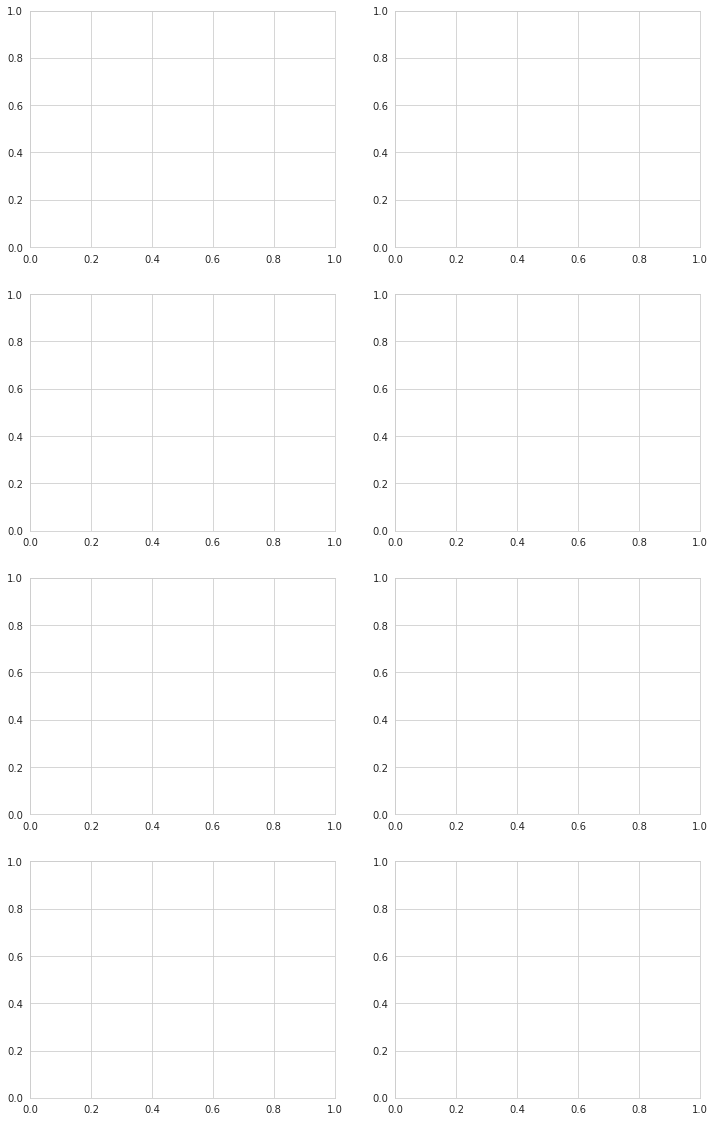

In [71]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=status_updates.reset_index(),
                y=indicator,
                x='new_stat',
                order=['TV', 'VR', 'WEB'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
#     axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB', fontsize=16, y=1.025)

In [ ]:
indicators = ['margin', 'weight', 'brutrevenue', 'linecount', 'PMVK', 'marginperkg', 'marginpercent', 'lineweight']
# indicators = ['weight', 'brutrevenue']
x = 'new_stat'
hue = None #'new_stat'
fig, axs = plt.subplots(nrows=len(indicators), figsize=(15 , 8* len(indicators)), )
stats = compute_distribution(data=status_updates,
                             indicators=indicators,
                             x=x,
                             hue=hue,
                             percentile_selection=.99,
                             IQR_factor_selection=2.,
                             IQR_factor_plot=.5,
                            )
plot_ranges = stats.T.groupby(level=0, axis=0).agg({'min_plot_selection': 'min',
                                                    'max_plot_selection': 'max',
                                                    'minimum_plot_range': 'min',
                                                    'maximum_plot_range': 'max',
                                                   })
reset = status_updates.reset_index()
for i, indicator in enumerate(indicators):
    sns.violinplot(data=(reset.loc[(reset[indicator] >= plot_ranges.loc[indicator, 'min_plot_selection']) &
                                   (reset[indicator] <= plot_ranges.loc[indicator, 'max_plot_selection'])
                                  ]),
                   y=indicator,
                   x=x,
                   cut=0.,
                   hue=hue,
#                    scale='count',
                   inner='quartile',
                   ax=axs[i])
    axs[i].set_ylim(plot_ranges.loc[indicator, 'minimum_plot_range'],
                    plot_ranges.loc[indicator, 'maximum_plot_range'])
    if show_mean[indicator] and not hue:
        axs[i].scatter(x=[0, 1, 2, 3], y=[reset[['orgacom', indicator]].groupby('orgacom').mean()], marker='s', color='k')
    axs[i].set_ylabel(libs[indicator], fontsize=14)
    axs[i].set_xlabel('Succursale', fontsize=14)
    axs[i].set_title('Répartition des commandes - clts avec au moins une commande Web', fontsize=16)
#     ax.set_xticks([])
#     axs[i].grid(linestyle='--')

In [ ]:
orders.groupby('origin2')['margin_clt_zscore'].describe().style.format('{:.3f}')

In [ ]:
orders = compute_zscores(orders, grouper_fields=['orgacom', 'client'], indicators=indicators)

In [ ]:
orders.info()

In [ ]:
reload(utils)

In [ ]:
fig, axs = utils.plot_distrib(data=orders,
                              filter=filter_otacos, 
                              indicators=['PMVK', 'PMVK_clt_zscore'],
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              hue='orgacom', #'origin2', 
                              hue_order=['2BRE', '1ALO', '1LRO', '1SOU',],
                              kind='violin',
                              percentile_selection=.98,
                              IQR_factor_selection=1.5,
                              IQR_factor_plot=1.,
                              show_means=True,
                             )

In [ ]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.violinplot(data=status_updates.loc[:].reset_index(),
                y=indicator,
                x='new_stat',
                order=['TV', 'VR', 'WEB'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                cut=0.,
#                 scale='count', 
                
                inner='quartile',   
                showfliers=False,
                
                whis=0.,
                **boxplot_args,
               )

#     axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
axs[0, 0].set_ylim(-5, 200)
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB', fontsize=16, y=1.025)

In [ ]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=status_updates.reset_index(),
                y=indicator,
                x='new_stat',
                order=['TV', 'VR', 'WEB'],
#                 order=['ZK', 'ZL', 'ZI'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
#     axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB', fontsize=16, y=1.025)

In [ ]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders.reset_index(),
                y=indicator + '_clt_zscore',
                x='clt_stat',
                order=['TV', 'VR', 'WEB'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
#     axs[x, y].get_legend().remove()
#     axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB - zscore', fontsize=16, y=1.025)

In [ ]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders.reset_index(),
                y=indicator + '_clt_zscore',
                x='orgacom',
#                 order=['TV', 'VR', 'WEB'],
                hue='clt_stat',
                hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
    axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB - zscore', fontsize=16, y=1.025)

## Plot des détails

In [ ]:
colors = {'TV': 'blue', 'VR': 'orange', 'WEB': 'green'}
sample_clt = (
# '0000210861'
# '0000020511'
'0000020697'
)
to_plot = orders.loc[idx[:, sample_clt, :]].copy()
to_plot['color'] = to_plot['origin2'].map(colors)
to_plot

In [ ]:
status_plot = status_updates.loc[idx[: , sample_clt, :]]
status_plot

In [ ]:
ind_ = 'brutrevenue'

p = figure(x_axis_type="datetime", title='Détail pour ' + sample_clt + " - " + ind_, plot_height=500, plot_width=800)
first_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[0],
#                           bottom=0.,
                          right=status_plot.index.get_level_values('date')[1],
                          fill_color='blue',
                          fill_alpha=.2,
                         )
p.add_layout(first_box)
second_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[1],
#                            bottom=0.,
#                            right=status_plot.index.get_level_values(2)[1],
                           fill_color='green',
                           fill_alpha=.2,
                          )

p.add_layout(second_box)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[0]) * 1000,
      y=(status_plot[ind_]).iloc[0],
      angle=0.,
      length=(datetime.timestamp(status_plot.index.get_level_values('date')[1]) - datetime.timestamp(status_plot.index.get_level_values('date')[0])) * 1000,
      line_color='blue',
      line_width=2)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[1]) * 1000,
      y=(status_plot[ind_]).iloc[1],
      angle=0.,
      length=0,
      line_color='green',
      line_width=2)
p.circle(to_plot.index.get_level_values('date'), to_plot[ind_], color=to_plot.color)
show(p)

In [ ]:
orders

In [ ]:
status_updates

In [ ]:
status_updates['end_date'] = status_updates.reset_index().groupby(['orgacom', 'client'])['date'].shift(-1)

In [ ]:
status_updates.reset_index(inplace=True)

In [ ]:
status_updates

In [ ]:
status_updates.groupby(['orgacom', 'client'])['date'].shift(-1)

In [ ]:
status_updates['end_date'] = (
    status_updates.groupby(['orgacom', 'client'])['date']
                  .shift(-1, fill_value=np.nan)
)

In [ ]:
status_updates.end_date - status_updates.date

In [ ]:
for indicator in indicators2:
    status_update[indicator] = 

In [ ]:
with pd.option_context('display.max_rows', None):
    print(status_updates.head(100))

## Données de base article

In [ ]:
matfields = {'code article':'object',
              'libellé article':'category',
              'code gamme':'category',
              'libellé gamme':'category', 
              'MARC-MMSTA':'category',
              'MARC-LVORM':'category',
              'MVKE-LVORM':'category',
              'MVKE-MVSTA':'category',
              'MARA-LVORM':'category',
              'Hiérarchie produit':'object',
              'Type d\'article':'category',
              'Division':'object', 
              'Org. commerciale':'category', 
              'Canal distribution':'category',
              'File d\'achat':'category', 
              'Marque industrielle':'category', 
              'Marque commerciale':'category', 
              'Grpe de marchandises':'category', 
              'Poids net':'float', 
              'Unité de p':'category',
              'V1':'category',
              'V2':'category',
              'V3':'category',
              'LG1':'category',
              'LG2':'category',         
             }

df_mat = pd.read_csv(Path('..') / 'data' / 'Référentiel_ConverteO_1ALO_Art_20191209.csv', 
                     sep=';', 
                     header=0, 
                     encoding="ISO-8859-1", 
                     dtype=matfields,
                     decimal=",")
df_mat.sample(5)

In [ ]:
num_mat_mask = df_mat['code article'].str.isnumeric()
df_mat.loc[num_mat_mask, 'code article'] = df_mat.loc[num_mat_mask, 'code article'].str.zfill(18)
df_mat.set_index('code article', inplace=True, drop=True)
df_mat.sample(5)

In [ ]:
if sum(df_mat.index.duplicated()):
    raise RuntimeError('Something went wrong on the material dataframe! Some indices are duplicated!')

# Feature engineering et nettoyage
## Fusion des datasets
### Ajout des données articles
On ajoute dans un premier temps les données article.

In [ ]:
data2 = (
data.merge(df_mat, how='left', left_on='material', right_index=True, validate='many_to_one', indicator=True)
)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données article.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some materials are missing in material master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un code article est en double dans les master data article).

In [ ]:
if len(data2) != len(data):
    raise RuntimeError('Looks like there were duplicate material numbers in material master data!')
data = data2
del data2
data.sample(5)

### Ajout des données client
On commence par fusionner les datasets.

In [ ]:
data2 = data.merge(df_clt,
                   how='left',
                   left_on=['orgacom', 'client'],
                   right_index=True,
                   validate='many_to_one',
                   indicator=True)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données client.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some clients are missing in client master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un couple (orgacom x client) est en double dans les master data client).

In [ ]:
if len(data2) != len(data):
    print('Looks like there were duplicate orgacom x client keys in client master data!')
data = data2
del data2
data.sample(5)